# <img src="https://img.icons8.com/fluency/96/000000/particles.png" style="height:50px;display:inline"> Deep Dynamic Latent Particles - Tutorial
---

<a href="">Tal Daniel</a>



<center>
    <a href="https://colab.research.google.com/github/taldatech/ddlp/blob/main/dlpv2_ddlp_walkthrough_tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</center>

* Paper: [**Unsupervised Object-centric Video Prediction with Deep Dynamic Latent Particles**, Tal Daniel and Aviv Tamar](https://arxiv.org/abs/2306.05957)
* GitHub: <a href="https://github.com/taldatech/ddlp">ddlp-pytorch</a>
* Wepage: <a href="https://taldatech.github.io/ddlp-web/">Deep Dynamic Latent Particles</a>

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/DDLP_GUI.gif?raw=true" style="height:250px">

### <img src="https://img.icons8.com/color/96/000000/loading.png" style="height:50px;display:inline"> Running Instructions
---
* This Jupyter Notebook can be opened locally with Anaconda, or online via Google Colab.
* To run online, go to https://colab.research.google.com/ and drag-and-drop the `dlpv2_ddlp_walkthrough_tutorial.ipynb` file.
    * On Colab, note the "directory" icon on the left, logs, figures and checkpoints are saved in this directory.
* To run the training on the image dataset, it is better to have a GPU. In Google Cola select `Runtime->Change runtime type->GPU`.

### <img src="https://img.icons8.com/color/96/000000/software-installer.png" style="height:50px;display:inline"> Requirements
---
* If running locally, make sure to set up the environment, preferably with <a href="https://anaconda.org/">Anaconda</a> by running `conda env create -f environment.yml` or with `pip` by running `pip install -r requirements.txt`.
* If running online on <a href="https://colab.research.google.com">Google Colab</a>, run the following cell to clone the repository.

In [1]:
# only run this cell if running on Google Colab
!git clone https://github.com/taldatech/ddlp.git
%cd ddlp

Cloning into 'deep-latent-particles-pytorch'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 155 (delta 67), reused 127 (delta 43), pack-reused 0
Receiving objects: 100% (155/155), 18.21 MiB | 9.09 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [1]:
# make sure the notebook is run from the root directory of the project (i.e., not from inside the `notebooks` dir)
%cd ..

/home/tal/projects/ddlp-pytorch


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Introduction](#-Introduction)
* [DLPv2 - Model](#-DLPv2---Model)
    * [Prior Encoder Module (FG)](#Prior-Encoder-Module-(FG))
    * [Posterior Encoder Module (FG)](#Posterior-Encoder-Module-(FG))
    * [Background Encoder Module (BG)](#Background-Encoder-Module-(BG))
    * [Decoder (FG + BG)](#Decoder-(FG-+-BG))
    * [DLPv2 - Hyperparameters and Example Usage](#-DLPv2---Hyperparameters-and-Example-Usage)
    * [Training Example - Random Shapes Dataset](#-Training-Example---Random-Shapes-Dataset)
    * [Visualization and Manipulation](#Visualization-and-Manipulation)
* [DDLP - Model](#-DDLP---Model)
    * [Particle Tracking Posterior](#Particle-Tracking-Posterior)
    * [Generative Predictive Dynamics with Particle Interaction Transformer (PINT)](#Generative-Predictive-Dynamics-with-Particle-Interaction-Transformer-(PINT))
    * [DDLP - Hyperparameters and Example Usage](#-DDLP---Hyperparameters-and-Example-Usage)
* [Credits](#-Credits)

In [2]:
# imports
# torch
import torch
# utils
from utils.util_func import get_config
# models
from models import ObjectDLP, ObjectDynamicsDLP
# datasets
from datasets.get_dataset import get_image_dataset
from datasets.shapes_ds import generate_shape_dataset_torch
# training
from train_dlp import train_dlp
# visualization
import matplotlib.pyplot as plt
# configs
import json

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

/home/tal/anaconda3/envs/dlp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### <img src="https://img.icons8.com/bubbles/50/000000/mention.png" style="height:50px;display:inline"> Introduction
---
* In this tutorial, we will give a brief overview of the deep latent particles (DLP) framework, and introduce DLPv2 and its extension to videos, DDLP.
* DLP is a new representation of visual data that disentangles object position from appearance. 
* DLP decomposes the visual input into low-dimensional latent ``particles''. 


A foreground latent particle $$ z = [z_p, z_s, z_d, z_t, z_f] \in \mathbb{R}^{6 + m} $$ is a disentangled latent variable composed of the following learned stochastic latent attributes:

* Position $ z_p \sim \mathcal{N}(\mu_p, \sigma_p^2) \in \mathbb{R}^2 $
* Scale $ z_s \sim \mathcal{N}(\mu_s, \sigma_s^2) \in \mathbb{R}^2 $
* Depth $ z_d \sim \mathcal{N}(\mu_d, \sigma_d^2) \in \mathbb{R} $
* Transparency $ z_t \sim \text{Beta}(a_t, b_t) \in \mathbb{R} $
* Visual features $ z_f \sim \mathcal{N}(\mu_f, \sigma_f^2) \in \mathbb{R}^m$, where $m$ is the dimension of learned visual features. 
* Background $z_{\text{bg}} \sim \mathcal{N}(\mu_{\text{bg}}, \sigma_{\text{bg}}^2) \in \mathbb{R}^{m_{\text{bg}}} $, always located in the center of the image and described only by $m_{\text{bg}}$ latent background visual features.

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/latent_particle_fig.png?raw=true" style="height:250px">

* DLP is trained with a variational autoencoder (VAE) objective with a special prior for particle positions based on a spatial-softmax architecture, and a modification of the evidence lower bound (ELBO) loss inspired by the Chamfer distance between particles.

### <img src="https://img.icons8.com/external-flaticons-flat-flat-icons/64/000000/external-neural-network-the-future-flaticons-flat-flat-icons.png" style="height:50px;display:inline"> DLPv2 - Model
---
* DLPv2 extends [DLP](https://taldatech.github.io/deep-latent-particles-web/), where the encoder is modified to account for the new attributes.
* We separate the model to *foreground* (FG) components and *background* (BG) components, which contribute to the final reconstruction of the input image.
* The basic blocks of DLPv2 are: *prior* encoder network (FG), posterior *attribute* encoder (FG), posterior *appearance* encoder (FG), object decoder (FG), background encoder (BG) and background decoder (BG).

#### Prior Encoder Module (FG)
---
* Similarly to the original DLP, to disentangle position from appearance of the particles, we consider a conditional VAE formulation, where a prior for the keypoints is explicitly learned given an image $x$.
* To generate a set of prior keypoints, termed *keypoint proposals* we follow a patch-based approach: the input $x \in \mathbb{R}^{H \times W \times 3}$ is split into $K_p$ patches of size $D \times D$ (usually $D\in\{8, 16\}$), and for each patch, a small convolutional neural network (CNN) followed by a spatial-softmax (SSM) layer outputs a single keypoint proposal.
* In practice, as the set of proposals can grow large with the number of patches, we *learn* to filter the keypoints to produce a subset of $L$ prior keypoints, where $L$ is a hyper-parameter. In DLPv2, the top-$L$ keypoints with the smallest sum of empirically-calculated SSM variance $s=\sigma_x^2 + \sigma_y^2 +\sigma_{xy}$ are chosen.
* Intuitively, in regions where the activation is sharp, we expect the softmax to produce a distribution with a small covariance values, which may indicate a non-background area-of-interest, e.g., objects, lines or corners, making the low-covariance a suitable criterion for detection and filtering (note that the SSM operation is differentiable).

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/prior_arch.png?raw=true" style="height:220px">
<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/ssm_fig.png?raw=true" style="height:250px">

In [ ]:
# THIS CELL IS NOT MEANT TO BE RUN
def encode_prior(self, x, global_kp=True):
    # x: [batch_size, cdim, image_size, image_size]
    # global_kp: set True to get the global coordinates within the image (instead of local KP inside the patch)
    batch_size, cdim, image_size, image_size = x.shape
    x_patches = self.img_to_patches(x)  # [batch_size, cdim, num_patches, patch_size, patch_size]
    x_patches = x_patches.permute(0, 2, 1, 3, 4)  # [batch_size, num_patches, cdim, patch_size, patch_size]
    x_patches = x_patches.contiguous().view(-1, cdim, self.patcher.patch_size, self.patcher.patch_size)
    _, z = self.enc(x_patches)  # [batch_size*num_patches, n_kp, features_dim, features_dim]
    mu_kp, var_kp = self.ssm(z, probs=False, variance=True)  # [batch_size * num_patches, n_kp, 2]
    mu_kp = mu_kp.view(batch_size, -1, self.n_kp, 2)  # [batch_size, num_patches, n_kp, 2]
    var_kp = var_kp.view(batch_size, mu_kp.shape[1], self.n_kp, -1)  # [batch_size, num_patches, n_kp, 3]
    if global_kp:
        mu_kp = self.get_global_kp(mu_kp)
    return mu_kp, var_kp

#### Posterior Encoder Module (FG)
---
* The encoding process is hierarchical and composed of 3 steps:<br> **(1)** *Anchor encoding* - a learned offset of $K$ keypoint anchors from the $L$ keypoint proposals. <br> **(2)** *Attribute encoding* - extraction of position offset, scale and transparency attributes for each particle.<br> **(3)** *Appearance encoding* - encoding the particles visual features.
* For **(1)**, we take the top-$K$ lowest SSM-variance keypoints out of the $L$ proposals to get a set of anchors $p_K$. Then, patches are extracted by using the prior keypoint proposals $p_L \in \mathbb{R}^{L \times 2}$ as input to a Spatial Transformer Network (STN). Next, a small CNN outputs features $M(x_P)$ from each patch which are flattened and fed through a feedforward network (FFN) to output the offset $o(p)$ of each anchor which is added to the original $K$ selected anchors to get a set of *modified anchor keypoints* $z_a = p_K + o_K  \in \mathbb{R}^{K \times 2}$. This set of keypoint anchors approximates objects location, and we proceed to the attribute encoding step where we lock on a more accurate position and extract the rest of the spatial attributes.
* For **(2)**, to extract the scale $z_s$, depth $z_d$ and transparency $z_t$ attributes for each particle, we extract glimpses from the anchor keypoints $z_a$ via STN as before, which are input to the *attribute encoder*  modeled as small CNN followed by a FC network that outputs the parameters of the distributions for each particle. In practice, the prior network is re-used as the *anchor encoder* $q_{\phi}(z_a|x)$ and the *attribute encoder* $q_{\phi}$ produces the offset from the anchors.
* For **(3)**, with all particle attributes in hand, we extract the particle visual features with the *appearance encoder* $q_{\phi}(z_f|x, z_p, z_s)$. 
* Note that since we used STN in all steps, all parameters are differentiable end-to-end. 

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/encoder_arch.png?raw=true" style="height:350px">

In [ ]:
# THIS CELL IS NOT MEANT TO BE RUN
def encode_all(self, x, deterministic=False, kp_init=None, cropped_objects_prev=None,
               scale_prev=None, refinement_iter=False):
    """
    2-stage encoding:
    0. if kp_init is None: create evenly spaced anchors. kp_init is z_base.
    1. attributes encoding: obj_on (z_t), depth (z_d), offset (z_o) and scale (z_s) encoding:
        produces [obj_on_a, obj_on_b] / [mu, logvar].
    2. features (z_f) encoding: [mu, logvar]
    """
    # kp_init: [batch_size, n_kp, 2] in [-1, 1]
    batch_size, ch, h, w = x.shape
    # 0. create or filter anchors
    if kp_init is None:
        # randomly sample n_kp_enc kp
        mu = torch.rand(batch_size, self.n_kp_enc, 2, device=x.device) * 2 - 1  # in [-1, 1]
    elif kp_init.shape[1] > self.n_kp_enc:
        mu = kp_init[:, :self.n_kp_enc]
    else:
        mu = kp_init
    logvar = torch.zeros_like(mu)
    z_base = mu # deterministic value for chamfer-kl
    kp_heatmap = None  # backward compatibility, this is not used
    # 1. posterior offsets and scale, it is okay of scale_prev is None
    scale_in = scale_prev
    cropped_objects_prev = cropped_objects_prev
    particle_stats_dict = self.particle_attribute_enc(x, z_base.detach(),
                                                      previous_objects=cropped_objects_prev,
                                                      z_scale=scale_in)
    # first iteration encodes the refined anchor (z_a), then a second one to lock on target better (z_o)
    if refinement_iter:
        mu_offset = particle_stats_dict['mu']
        mu = z_base + mu_offset
        z_base = mu + 0.0 * logvar
        if scale_prev is None:
            scale_prev = None if (noisy or warmup) else particle_stats_dict['mu_scale'].detach()
        cropped_objects_prev = None if (noisy or warmup) else cropped_objects_prev
        particle_stats_dict = self.particle_attribute_enc(x, z_base.detach(),
                                                          previous_objects=cropped_objects_prev,
                                                          z_scale=scale_prev)

    mu_offset = particle_stats_dict['mu']
    logvar_offset = particle_stats_dict['logvar']
    mu_scale = particle_stats_dict['mu_scale']
    logvar_scale = particle_stats_dict['logvar_scale']
    lobj_on_a = particle_stats_dict['lobj_on_a']
    lobj_on_b = particle_stats_dict['lobj_on_b']
    mu_depth = particle_stats_dict['mu_depth']
    logvar_depth = particle_stats_dict['logvar_depth']
    # final position
    mu_tot = z_base + mu_offset
    logvar_tot = logvar_offset

    obj_on_a = lobj_on_a.exp().clamp_min(1e-5)
    obj_on_b = lobj_on_b.exp().clamp_min(1e-5)
    obj_on_beta_dist = torch.distributions.Beta(obj_on_a, obj_on_b)

    # reparameterize
    if deterministic:
        z = mu_tot
        z_offset = mu_offset
        z_scale = mu_scale
        z_depth = mu_depth
        z_obj_on = obj_on_beta_dist.mean
    else:
        z = reparameterize(mu_tot, logvar_tot)
        z_scale = reparameterize(mu_scale, logvar_scale)
        z_depth = reparameterize(mu_depth, logvar_depth)
        z_obj_on = obj_on_beta_dist.rsample()

    # 2. posterior attributes: obj_on, depth and visual features
    obj_enc_out = self.particle_features_enc(x, z, z_scale=z_scale.detach())

    mu_features = obj_enc_out['mu_features']
    logvar_features = obj_enc_out['logvar_features']
    cropped_objects = obj_enc_out['cropped_objects']

    # reparameterize
    if deterministic:
        z_features = mu_features
    else:
        z_features = reparameterize(mu_features, logvar_features)

    encode_dict = {'mu': mu, 'logvar': logvar, 'z_base': z_base, 'z': z, 'kp_heatmap': kp_heatmap,
                   'mu_features': mu_features, 'logvar_features': logvar_features, 'z_features': z_features,
                   'obj_on_a': obj_on_a, 'obj_on_b': obj_on_b, 'obj_on': z_obj_on,
                   'mu_depth': mu_depth, 'logvar_depth': logvar_depth, 'z_depth': z_depth,
                   'cropped_objects': cropped_objects,
                   'mu_scale': mu_scale, 'logvar_scale': logvar_scale, 'z_scale': z_scale,
                   'mu_offset': mu_offset, 'logvar_offset': logvar_offset, 'z_offset': z_offset}
    return encode_dict

#### Background Encoder Module (BG)
---
* We assign an abstract particle for the background that is always located in the center of the image and its visual features $z_{\text{bg}}$ are encoded with a *background encoder* $q_{\phi}(z_{\text{bg}}|x, z_p)$ which is a CNN followed by a FC network, similarly to the original DLP. 
* The input to the background encoder is a *masked image* -- the posterior keypoints $z_p$ are used to generate $K$ masks of size $S \times S$ that mask out the corresponding regions of the original image $x$.

In [ ]:
# THIS CELL IS NOT MEANT TO BE RUN
def encode_bg(self, x, masks=None):
    # x: [bs, ch, image_size, image_size]
    # masks: [bs, 1, image_size, image_size]
    batch_size, _, features_dim, _ = x.shape
    # bg features
    if masks is not None:
        x_in = x * masks
    else:
        x_in = x
    _, cnn_features = self.bg_cnn_enc(x_in)
    cnn_features = cnn_features.view(batch_size, -1)  # flatten
    bg_enc_out = self.bg_enc(cnn_features)  # [bs,, 2 * learned_features_dim]
    mu_bg, logvar_bg = bg_enc_out.chunk(2, dim=-1)
    
    if deterministic:
        z_bg = mu_bg
    else:
        z_bg = reparameterize(mu_bg, logvar_bg)
    z_kp = torch.zeros(mu_bg.shape[0], 1, 2, device=x.device, dtype=torch.float)  # center of the image
    encode_dict = {'mu_bg': mu_bg, 'logvar_bg': logvar_bg, 'z_bg': z_bg, 'z_kp': z_kp}

    return encoder_dict

#### Decoder (FG + BG)
---
* The decoder is composed of an *object decoder* and a *background decoder*. 
* The object decoder is a fully-connected layer followed by a small upsampling CNN that takes in a single latent particle features $z_f^{(i)}$, and decodes an RGBA patch $\tilde{x^p_i} \in \mathbb{R}^{S \times S \times 4}$, a reconstruction of each object's appearance. Then, the depth $z_s$ and transparency $z_t$ are used to factor the alpha channels of the object, which essentially determines the order of stitching and the visibility of the particle, and $z_p$ and $z_s$ are used to position and scale the decoded patches in the full $H \times W$ canvas, $\hat{x}_{\text{fg}}$, using a STN.
* The background decoder is similar in design to standard VAEs, taking in $z_{\text{bg}}$ which is upsampled via a FC layer followed by a CNN to generate $\hat{x}_{\text{bg}}$.
* Finally, the foreground components and the background are stitched together by $\alpha \times \hat{x}_{\text{fg}} + (1-\alpha)\times \hat{x}_{\text{bg}}$, where the masks $\alpha$ are the last channel of the RGBA glimpse output of the decoder.

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/decoder_arch.png?raw=true" style="height:350px">

In [ ]:
# THIS CELL IS NOT MEANT TO BE RUN
# We show important steps in building the reconstructed image

# object latents -> RGBA patches -> translate them to their original position on the canvas
def get_objects_alpha_rgb(self, z_kp, z_features, z_scale=None, translation=None, noisy=False):
    # decode the latent particles into RGBA glimpses and place them on the canvas
    dec_objects = self.object_dec(z_features)  # [bs * n_kp, 4, patch_size, patch_size]
    dec_objects = dec_objects.view(-1, self.n_kp_enc,
                                   *dec_objects.shape[1:])  # [bs, n_kp, 4, patch_size, patch_size]
    # translate patches - place the decoded glimpses on the canvas
    dec_objects_trans = self.translate_patches(z_kp, dec_objects, z_scale, translation)
    dec_objects_trans = dec_objects_trans.clamp(0, 1)  # STN can change values to be < 0
    # dec_objects_trans: [bs, n_kp, 3, im_size, im_size]
    # multiply by alpha channel
    a_obj, rgb_obj = torch.split(dec_objects_trans, [1, 3], dim=2)
    return dec_objects, a_obj, rgb_obj

# factorize the depth
def get_objects_alpha_rgb_with_depth(self, a_obj, rgb_obj, obj_on, z_depth, eps=1e-5):
    # stitching the glimpses by factoring the alpha maps and the particle's inferred depth
    # obj_on: [bs, n_kp, 1]
    # z_depth: [bs, n_kp, 1]
    # turn off inactive particles
    a_obj = obj_on[:, :, None, None, None] * a_obj  # [bs, n_kp, 1, im_size, im_size]
    rgba_obj = a_obj * rgb_obj
    # importance map
    importance_map = a_obj * torch.sigmoid(-z_depth[:, :, :, None, None])
    # normalize
    importance_map = importance_map / (torch.sum(importance_map, dim=1, keepdim=True) + eps)
    # this imitates softmax to move objects on the depth axis
    dec_objects_trans = (rgba_obj * importance_map).sum(dim=1)
    alpha_mask = 1.0 - (importance_map * a_obj).sum(dim=1)
    a_obj = importance_map * a_obj
    return a_obj, alpha_mask, dec_objects_trans

def decode_all(self, z, z_features, z_bg, obj_on, z_depth, z_scale):
    # a wrapper function to convert latent particles to an RGB image
    # foreground
    fg_dict = self.fg_module.decode_all(z, z_features, obj_on, z_depth=z_depth, z_scale=z_scale)
    dec_objects = fg_dict['dec_objects']
    dec_objects_trans = fg_dict['dec_objects_trans']
    alpha_masks = fg_dict['alpha_masks']
    bg_mask = fg_dict['bg_mask']
    # background
    bg = self.bg_module.decode_all(z_bg)
    # stitch the final image
    rec = bg_mask * bg + dec_objects_trans
    decoder_out = {'rec': rec, 'dec_objects': dec_objects, 'dec_objects_trans': dec_objects_trans,
                   'bg': bg, 'alpha_masks': alpha_masks}
    return decoder_out

### <img src="https://img.icons8.com/external-bearicons-gradient-bearicons/64/external-Example-miscellany-texts-and-badges-bearicons-gradient-bearicons.png" style="height:50px;display:inline"> DLPv2 - Hyperparameters and Example Usage
---
* We will now create an instance of DLPv2 and look at its functions outputs.
* More details are available in `/docs/example_usage.py`.

In [3]:
# example hyper-parameters
batch_size = 32
beta_kl = 0.1
beta_rec = 1.0
kl_balance = 0.001  # balance between spatial attributes (x, y, scale, depth) and visual features
n_kp_enc = 12
n_kp_prior = 15
patch_size = 8  # patch size for the prior to generate prior proposals
learned_feature_dim = 6  # visual features
anchor_s = 0.25  # effective patch size for the posterior: anchor_s * image_size

image_size = 64
ch = 3
enc_channels = [32, 64, 128]
prior_channels = (32, 32, 64)

use_correlation_heatmaps = False  # for tracking, set True to use correlation heatmaps between patches

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print("--- DLPv2 ---")

# create model
model = ObjectDLP(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                  image_size=image_size, learned_feature_dim=learned_feature_dim,
                  patch_size=patch_size, n_kp_enc=n_kp_enc, n_kp_prior=n_kp_prior,
                  anchor_s=anchor_s, use_correlation_heatmaps=use_correlation_heatmaps).to(device)
print(f'model.info():')
print(model.info())

--- DLPv2 ---
model.info():
prior (patch) kp filtering: 64 -> prior kp: 15
prior (patch) kp filtering method: variance
prior patch size: 8
# posterior particles: 12
particle visual feature dim: 6
bg visual feature dim: 6
posterior object patch size: 16
cnn pre-pool out sizes: prior-torch.Size([64, 2, 2]), obj enc-torch.Size([64, 4, 4]), bg enc-torch.Size([128, 16, 16])
object decoder # upsampling layers: 1
tracking: False, correlation maps for tracking: False
trainable parameters: 4614508 (4.6145M)
estimated size on disk: 17.603MB



In [4]:
# dummy data
x = torch.rand(batch_size, ch, image_size, image_size, device=device)
# complete forward
model_output = model(x)
# let's see what's inside
print(f'model(x) output:')
for k in model_output.keys():
    print(f'{k}: {model_output[k].shape}')

model(x) output:
kp_p: torch.Size([32, 15, 2])
rec: torch.Size([32, 3, 64, 64])
mu: torch.Size([32, 12, 2])
logvar: torch.Size([32, 12, 2])
z: torch.Size([32, 12, 2])
z_base: torch.Size([32, 12, 2])
z_kp_bg: torch.Size([32, 1, 2])
mu_offset: torch.Size([32, 12, 2])
logvar_offset: torch.Size([32, 12, 2])
mu_features: torch.Size([32, 12, 6])
logvar_features: torch.Size([32, 12, 6])
z_features: torch.Size([32, 12, 6])
bg: torch.Size([32, 3, 64, 64])
mu_bg: torch.Size([32, 6])
logvar_bg: torch.Size([32, 6])
z_bg: torch.Size([32, 6])
cropped_objects_original: torch.Size([32, 12, 3, 16, 16])
obj_on_a: torch.Size([32, 12])
obj_on_b: torch.Size([32, 12])
obj_on: torch.Size([32, 12])
dec_objects_original: torch.Size([32, 12, 4, 16, 16])
dec_objects: torch.Size([32, 3, 64, 64])
mu_depth: torch.Size([32, 12, 1])
logvar_depth: torch.Size([32, 12, 1])
z_depth: torch.Size([32, 12, 1])
mu_scale: torch.Size([32, 12, 2])
logvar_scale: torch.Size([32, 12, 2])
z_scale: torch.Size([32, 12, 2])
alpha_masks

`kp_p`: torch.Size([32, 15, 2])  # prior proposals

`rec`: torch.Size([32, 3, 64, 64])  # full reconstructions

`mu`: torch.Size([32, 12, 2])  # position mu

`logvar`: torch.Size([32, 12, 2])  # position logvar

`z`: torch.Size([32, 12, 2])  # position z

`z_base`: torch.Size([32, 12, 2])  # position anchors (mu = z_base + mu_offset)

`z_kp_bg`: torch.Size([32, 1, 2])  # constants (0.0, 0.0) for the bg kp

`mu_offset`: torch.Size([32, 12, 2])  # position offset mu

`logvar_offset`: torch.Size([32, 12, 2])  # position offset logvar

`mu_features`: torch.Size([32, 12, 6])  # visual features mu

`logvar_features`: torch.Size([32, 12, 6])  # visual features logvar

`z_features`: torch.Size([32, 12, 6])  # visual features z

`bg`: torch.Size([32, 3, 64, 64])  # bg reconstructions

`mu_bg`: torch.Size([32, 6])  # bg visual features mu

`logvar_bg`: torch.Size([32, 6])  # bg visual features logvar

`z_bg`: torch.Size([32, 6])  # bg visual features z

`cropped_objects_original`: torch.Size([32, 12, 3, 16, 16])  # extracted patches from the original image

`obj_on_a`: torch.Size([32, 12])  # transparency beta distribution "a" parameter

`obj_on_b`: torch.Size([32, 12])  # transparency beta distribution "b" parameter

`obj_on`: torch.Size([32, 12])  # transparency sample per particle

`dec_objects_original`: torch.Size([32, 12, 4, 16, 16])  # decoded glimpses (rgb + alpha channel)

`dec_objects`: torch.Size([32, 3, 64, 64])  # decoded foreground (no bg)

`mu_depth`: torch.Size([32, 12, 1])  # depth mu

`logvar_depth`: torch.Size([32, 12, 1])  # depth logvar

`z_depth`: torch.Size([32, 12, 1])  # depth z

`mu_scale`: torch.Size([32, 12, 2])  # scale mu

`logvar_scale`: torch.Size([32, 12, 2])  # scale logvar

`z_scale`: torch.Size([32, 12, 2])  # scale z

`alpha_masks`: torch.Size([32, 12, 1, 64, 64])  # objects masks

In [5]:
# loss calculation
all_losses = model.calc_elbo(x, model_output, beta_kl=beta_kl,
                             beta_rec=beta_rec, kl_balance=kl_balance,
                             recon_loss_type="mse")
# let's see what's inside
print(f'model.calc_elbo(): model losses:')
for k in all_losses.keys():
    print(f'{k}: {all_losses[k]}')

model.calc_elbo(): model losses:
loss: 1092.222412109375
psnr: 10.777459144592285
kl: 648.3236694335938
loss_rec: 1027.3900146484375
obj_on_l1: 6.027878761291504
loss_kl_kp: 260.6050109863281
loss_kl_feat: 0.1483308970928192
loss_kl_obj_on: 14.374871253967285
loss_kl_scale: 373.34356689453125
loss_kl_depth: 0.007742627523839474


`loss`: the complete loss (for `loss.backward()`)

`psnr`: mean PSNR

`kl`: complete kl-divergence (of all components)

`loss_rec`: reconstruction loss

`obj_on_l1`: if all particles are "on" then obj_on_l1=n_particles, effective # of visible particles

`loss_kl_kp`: kl of the position

`loss_kl_feat`: kl of the visual features

`loss_kl_obj_on`: kl of the transparency

`loss_kl_scale`: kl of the scale

`loss_kl_depth`: kl of the depth

###  <img src="https://img.icons8.com/external-icongeek26-linear-colour-icongeek26/64/000000/external-shapes-graphic-design-icongeek26-linear-colour-icongeek26.png" style="height:50px;display:inline"> Training Example - Random Shapes Dataset
---
* The model is optimized as a variational autoencoder (VAE) with objective of maximizing the evidence lower bound (ELBO): $$ \log p_\theta(x) \geq \mathbb{E}_{q(z|x)} \left[\log p_\theta(x|z)\right] - KL(q(z|x) \Vert p(z)) \doteq ELBO(x) $$
* The ELBO is decomposed to the <i>reconstruction error</i> and a <i>KL-divergence</i> regularization term.
* Let's take a look at data for the tutorial: images of random shapes of different sizes and colors.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 832.53it/s]

sample_images: <torch.utils.data.dataset.TensorDataset object at 0x7fa3d43ef1c0>


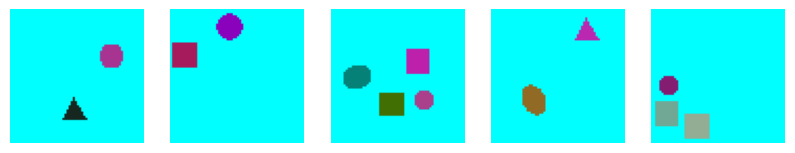

In [6]:
%matplotlib inline
sample_images = generate_shape_dataset_torch(img_size=64, num_images=5)  # [5, 3, 64, 64]
print(f'sample_images: {sample_images}')
# plot
fig = plt.figure(figsize=(10, 2))
for i in range(len(sample_images)):
    ax = fig.add_subplot(1, len(sample_images), i + 1)
    ax.imshow(sample_images[i][0].permute(1, 2, 0).data.cpu())
    ax.set_axis_off()

#### Hyper-parameters
---
DLP has some trivial hyper-parameters just like any other model (e.g., learning rate, batch size and etc...), and the rest are described below:

* `ds`: dataset name (str)
* `enc_channels`: channels for the posterior CNN (takes in the whole image)
* `prior_channels`: channels for prior CNN (takes in patches)
* `n_kp`: number of kp to extract from each (!) patch
* `n_kp_prior`: number of kp to filter from the set of prior kp (of size n_kp x num_patches)
* `n_kp_enc`: number of posterior kp to be learned (this is the actual number of kp that will be learnt)
* `pad_mode`: padding for the CNNs, 'zeros' or  'replicate' (default)
* `patch_size`: patch size for the prior KP proposals network (not to be confused with the glimpse size)
* `learned_feature_dim`: the latent visual features dimensions extracted from glimpses.
* `bg_learned_feature_dim`: the latent visual features dimensions extracted from the background.
* `anchor_s`: defines the glimpse size as a ratio of image_size (e.g., 0.25 for image_size=128 -> glimpse_size=32)
* `topk`: the number top-k particles with the lowest variance (highest confidence) to filter for the plots.
* `warmup_epoch`: (used for the Object Model) number of epochs where only the object decoder is trained.
* `recon_loss_type`: tpe of pixel reconstruction loss ("mse", "vgg").
* `beta_rec`: coefficient for the reconstruction loss (we use 1.0).
* `beta_kl`: coefficient for the KL divergence term in the loss.
* `kl_balance`: coefficient for the balance between the KL of the attributes and the KL of the visual features, `kl_loss = beta_kl * (kl_balance * chamfer_kl + kl_attributes + kl_balance * kl_features)`
* `filtering_heuristic`: method to filter particles from the prior proposals - 'distance' (DLPv1, distance from patch center), `varaince` (DLPv2, SSM varaince as described above), `random` (self-explanatory), `none` (uses MLP-Mixer to learn coordiantes).
* `use_tracking`: track particles across frames (used in DDLP, but can also be used with DLPv2, given that the dataset returns sequence of frames).
* `use_correlation_heatmaps`: if `use_tracking` is `True` and `use_correlation_heatmaps` is `True`, the tracking process will compute correlation heatmaps between consecutive frames to better lock on the particle location.
* `scheduler_gamma`: we use `StepLR` scheduler for the learning rate, this hyper-parameter determines the LR decrease factor.
* DDLP related hyper-parameters: `timestep_horizon`, `pint_layers`, `pint_heads`, `pint_dim`, `beta_dyn`, `beta_dyn_rec`, `num_static_frames`, `animation_fps`, `cond_steps`, `animation_horizon`

In [7]:
# lets take a look at the config file and modify it for the tutorial
shapes_config = get_config('configs/shapes.json')
shapes_config['beta_kl'] = 0.05
shapes_config['n_kp_enc'] = 10
shapes_config['n_kp_prior'] = 64
shapes_config['run_prefix'] = '_dlp_tut'
shapes_config['filtering_heuristic'] = 'variance'
shapes_config['num_epochs'] = 50
print(shapes_config)
# save config
conf_path = f'configs/dlp_tut.json'
with open(conf_path, 'w') as outfile:
    json.dump(shapes_config, outfile, indent=2)

{'ds': 'shapes', 'root': None, 'device': 'cuda', 'batch_size': 32, 'lr': 0.0002, 'kp_activation': 'tanh', 'pad_mode': 'replicate', 'load_model': False, 'pretrained_path': None, 'num_epochs': 50, 'n_kp': 1, 'recon_loss_type': 'mse', 'sigma': 1.0, 'beta_kl': 0.05, 'beta_rec': 1.0, 'patch_size': 8, 'topk': 10, 'n_kp_enc': 10, 'eval_epoch_freq': 1, 'learned_feature_dim': 6, 'n_kp_prior': 64, 'weight_decay': 0.0, 'kp_range': [-1, 1], 'warmup_epoch': 1, 'dropout': 0.0, 'iou_thresh': 0.2, 'anchor_s': 0.25, 'kl_balance': 0.001, 'image_size': 64, 'ch': 3, 'enc_channels': [32, 64, 128], 'prior_channels': [16, 32, 64], 'timestep_horizon': 10, 'predict_delta': True, 'beta_dyn': 1.0, 'scale_std': 1.0, 'offset_std': 1.0, 'obj_on_alpha': 0.1, 'obj_on_beta': 0.1, 'beta_dyn_rec': 1.0, 'num_static_frames': 4, 'pint_layers': 6, 'pint_heads': 8, 'pint_dim': 256, 'run_prefix': '_dlp_tut', 'animation_horizon': 100, 'eval_im_metrics': True, 'use_resblock': False, 'scheduler_gamma': 0.95, 'adam_betas': [0.9, 

In [8]:
# train
%matplotlib agg
model = train_dlp(conf_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:17<00:00, 2303.37it/s]


prior (patch) kp filtering: 64 -> prior kp: 64
prior (patch) kp filtering method: variance
prior patch size: 8
# posterior particles: 10
particle visual feature dim: 6
bg visual feature dim: 6
posterior object patch size: 16
cnn pre-pool out sizes: prior-torch.Size([64, 2, 2]), obj enc-torch.Size([64, 4, 4]), bg enc-torch.Size([128, 16, 16])
object decoder # upsampling layers: 1
tracking: False, correlation maps for tracking: False
trainable parameters: 4578460 (4.5785M)
estimated size on disk: 17.465MB

Adjusting learning rate of group 0 to 2.0000e-04.


epoch #0 (warmup): 100%|███████████████████████████████████████████| 1250/1250 [01:10<00:00, 17.70it/s, kl=0.396, loss=12.5, on_l1=6.24, rec=12.5]


Adjusting learning rate of group 0 to 1.9000e-04.
epoch 0 summary
loss: 49.456, rec: 46.114, kl: 66.832
kl_balance: 0.001, kl_kp: 19.102, kl_feat: 308.179
kl_scale: 47.040, kl_depth: 0.001, kl_obj_on: 0.382
mu max: 0.9598026871681213, mu min: -0.9579195976257324
mu offset max: 0.00034493952989578247, mu offset min: -0.00023021548986434937
val loss (freq: 1): 100000000.000, best: 100000000.000 @ epoch: 0
obj_on max: 0.9999998807907104, obj_on min: 6.335063533874517e-19
scale max: 0.1876363903284073, scale min: 0.18738868832588196
depth max: 0.00047338567674160004, depth min: -0.00027572549879550934
val lpips (freq: 1): 100000000.000, best: 100000000.000 @ epoch: 0

bb scores: max: 9.21, min: 0.00, mean: 5.74

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2356.64it/s]


validation loss: 2595.674

validation loss updated: 100000000.000 -> 2595.674



epoch #1 (noisy): 100%|███████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.55it/s, kl=55.2, loss=131, on_l1=5.29, rec=129]


Adjusting learning rate of group 0 to 1.8050e-04.
epoch 1 summary
loss: 310.466, rec: 307.837, kl: 52.580
kl_balance: 0.001, kl_kp: 21.847, kl_feat: 512.894
kl_scale: 7.025, kl_depth: 51.122, kl_obj_on: 23.144
mu max: 0.9047810435295105, mu min: -0.8628158569335938
mu offset max: 0.1742224395275116, mu offset min: -0.12809531390666962
val loss (freq: 1): 2595.674, best: 2595.674 @ epoch: 0
obj_on max: 0.9266635775566101, obj_on min: 0.1958225518465042
scale max: 0.21753080189228058, scale min: 0.19027623534202576
depth max: -0.25085583329200745, depth min: -1.4959204196929932
val lpips (freq: 1): 100000000.000, best: 100000000.000 @ epoch: 0

bb scores: max: 14.13, min: 2.56, mean: 7.36

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2330.90it/s]


validation loss: 91.431

validation loss updated: 2595.674 -> 91.431



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.76it/s]


validation: lpips: 0.189, psnr: 22.334, ssim: 0.622

validation lpips updated: 100000000.000 -> 0.189



epoch #2: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.54it/s, kl=147, loss=31.8, on_l1=8.54, rec=24.4]


Adjusting learning rate of group 0 to 1.7147e-04.
epoch 2 summary
loss: 46.952, rec: 39.670, kl: 145.653
kl_balance: 0.001, kl_kp: 68.463, kl_feat: 605.170
kl_scale: 44.124, kl_depth: 24.531, kl_obj_on: 32.435
mu max: 0.8263490200042725, mu min: -0.9703092575073242
mu offset max: 0.14034375548362732, mu offset min: -0.1455783247947693
val loss (freq: 1): 91.431, best: 91.431 @ epoch: 1
obj_on max: 0.9999956488609314, obj_on min: 0.16856524348258972
scale max: 0.2960526943206787, scale min: 0.1744144856929779
depth max: -0.9534350633621216, depth min: -1.7350070476531982
val lpips (freq: 1): 0.189, best: 0.189 @ epoch: 1

bb scores: max: 19.00, min: 1.97, mean: 14.17

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2297.41it/s]


validation loss: 31.156

validation loss updated: 91.431 -> 31.156



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.53it/s]


validation: lpips: 0.039, psnr: 28.062, ssim: 0.771

validation lpips updated: 0.189 -> 0.039



epoch #3: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.09it/s, kl=150, loss=28.4, on_l1=8.27, rec=20.9]


Adjusting learning rate of group 0 to 1.6290e-04.
epoch 3 summary
loss: 28.728, rec: 21.485, kl: 144.871
kl_balance: 0.001, kl_kp: 72.590, kl_feat: 656.592
kl_scale: 45.552, kl_depth: 16.573, kl_obj_on: 26.056
mu max: 0.8081141710281372, mu min: -0.9387999773025513
mu offset max: 0.21826054155826569, mu offset min: -0.2416737675666809
val loss (freq: 1): 31.156, best: 31.156 @ epoch: 2
obj_on max: 0.9999998807907104, obj_on min: 0.24762721359729767
scale max: 0.27518436312675476, scale min: 0.16766764223575592
depth max: 1.270086646080017, depth min: -2.323307752609253
val lpips (freq: 1): 0.039, best: 0.039 @ epoch: 2

bb scores: max: 20.38, min: 3.11, mean: 14.74

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2304.09it/s]


validation loss: 26.088

validation loss updated: 31.156 -> 26.088



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.31it/s]


validation: lpips: 0.033, psnr: 29.624, ssim: 0.838

validation lpips updated: 0.039 -> 0.033



epoch #4: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.55it/s, kl=147, loss=27.8, on_l1=8.64, rec=20.4]


Adjusting learning rate of group 0 to 1.5476e-04.
epoch 4 summary
loss: 24.863, rec: 17.645, kl: 144.365
kl_balance: 0.001, kl_kp: 74.910, kl_feat: 640.035
kl_scale: 45.093, kl_depth: 23.696, kl_obj_on: 23.699
mu max: 0.792693018913269, mu min: -1.0020548105239868
mu offset max: 0.18424411118030548, mu offset min: -0.1669313609600067
val loss (freq: 1): 26.088, best: 26.088 @ epoch: 3
obj_on max: 0.9999998807907104, obj_on min: 0.24760721623897552
scale max: 0.2845818102359772, scale min: 0.1819409430027008
depth max: 1.9113836288452148, depth min: -2.6728687286376953
val lpips (freq: 1): 0.033, best: 0.033 @ epoch: 3

bb scores: max: 19.75, min: 3.02, mean: 15.00

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2286.22it/s]


validation loss: 25.270

validation loss updated: 26.088 -> 25.270



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.32it/s]


validation: lpips: 0.034, psnr: 30.107, ssim: 0.889



epoch #5: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.97it/s, kl=145, loss=22.2, on_l1=8.05, rec=14.9]


Adjusting learning rate of group 0 to 1.4702e-04.
epoch 5 summary
loss: 22.986, rec: 15.781, kl: 144.094
kl_balance: 0.001, kl_kp: 76.192, kl_feat: 639.448
kl_scale: 44.780, kl_depth: 27.005, kl_obj_on: 22.455
mu max: 0.7885143160820007, mu min: -1.029693841934204
mu offset max: 0.14667917788028717, mu offset min: -0.1599346399307251
val loss (freq: 1): 25.270, best: 25.270 @ epoch: 4
obj_on max: 0.9999998807907104, obj_on min: 0.19885270297527313
scale max: 0.2710168659687042, scale min: 0.17547164857387543
depth max: 3.0800552368164062, depth min: -1.886427640914917
val lpips (freq: 1): 0.034, best: 0.033 @ epoch: 3

bb scores: max: 21.05, min: 2.28, mean: 14.61

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2264.54it/s]


validation loss: 22.524

validation loss updated: 25.270 -> 22.524



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.13it/s]


validation: lpips: 0.027, psnr: 31.629, ssim: 0.932

validation lpips updated: 0.033 -> 0.027



epoch #6: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:14<00:00, 16.83it/s, kl=145, loss=25.5, on_l1=8.53, rec=18.3]


Adjusting learning rate of group 0 to 1.3967e-04.
epoch 6 summary
loss: 20.406, rec: 13.165, kl: 144.809
kl_balance: 0.001, kl_kp: 77.516, kl_feat: 649.120
kl_scale: 44.024, kl_depth: 31.302, kl_obj_on: 22.589
mu max: 0.8325003385543823, mu min: -1.1027201414108276
mu offset max: 0.20528995990753174, mu offset min: -0.21022562682628632
val loss (freq: 1): 22.524, best: 22.524 @ epoch: 5
obj_on max: 0.9999998807907104, obj_on min: 0.2389151155948639
scale max: 0.27571287751197815, scale min: 0.16994500160217285
depth max: 3.64043927192688, depth min: -2.195039749145508
val lpips (freq: 1): 0.027, best: 0.027 @ epoch: 5

bb scores: max: 20.31, min: 3.04, mean: 15.16

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2383.80it/s]


validation loss: 20.288

validation loss updated: 22.524 -> 20.288



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.38it/s]


validation: lpips: 0.028, psnr: 31.998, ssim: 0.954



epoch #7: 100%|████████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.06it/s, kl=146, loss=22, on_l1=8.33, rec=14.7]


Adjusting learning rate of group 0 to 1.3268e-04.
epoch 7 summary
loss: 20.765, rec: 13.504, kl: 145.205
kl_balance: 0.001, kl_kp: 77.481, kl_feat: 653.545
kl_scale: 44.414, kl_depth: 32.719, kl_obj_on: 22.624
mu max: 0.8114792108535767, mu min: -1.2539122104644775
mu offset max: 0.22453045845031738, mu offset min: -0.33389168977737427
val loss (freq: 1): 20.288, best: 20.288 @ epoch: 6
obj_on max: 0.9999998807907104, obj_on min: 0.2964421212673187
scale max: 0.27268779277801514, scale min: 0.17481830716133118
depth max: 4.593421936035156, depth min: -1.143267273902893
val lpips (freq: 1): 0.028, best: 0.027 @ epoch: 5

bb scores: max: 20.31, min: 3.04, mean: 15.05

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2341.16it/s]


validation loss: 18.502

validation loss updated: 20.288 -> 18.502



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.96it/s]


validation: lpips: 0.024, psnr: 32.560, ssim: 0.969

validation lpips updated: 0.027 -> 0.024



epoch #8: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.00it/s, kl=145, loss=22.5, on_l1=8.46, rec=15.3]


Adjusting learning rate of group 0 to 1.2605e-04.
epoch 8 summary
loss: 18.525, rec: 11.308, kl: 144.333
kl_balance: 0.001, kl_kp: 77.859, kl_feat: 655.997
kl_scale: 43.544, kl_depth: 31.589, kl_obj_on: 22.243
mu max: 0.8311349749565125, mu min: -1.0270615816116333
mu offset max: 0.16976182162761688, mu offset min: -0.10474425554275513
val loss (freq: 1): 18.502, best: 18.502 @ epoch: 7
obj_on max: 0.9999998807907104, obj_on min: 0.18068240582942963
scale max: 0.27261507511138916, scale min: 0.17266184091567993
depth max: 4.278763771057129, depth min: -1.312171220779419
val lpips (freq: 1): 0.024, best: 0.024 @ epoch: 7

bb scores: max: 19.92, min: 1.62, mean: 15.06

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2355.03it/s]


validation loss: 18.491

validation loss updated: 18.502 -> 18.491



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.23it/s]


validation: lpips: 0.023, psnr: 33.127, ssim: 0.977

validation lpips updated: 0.024 -> 0.023



epoch #9: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:14<00:00, 16.86it/s, kl=135, loss=21.1, on_l1=8.51, rec=14.3]


Adjusting learning rate of group 0 to 1.1975e-04.
epoch 9 summary
loss: 18.645, rec: 11.578, kl: 141.348
kl_balance: 0.001, kl_kp: 75.764, kl_feat: 649.975
kl_scale: 42.696, kl_depth: 36.927, kl_obj_on: 22.201
mu max: 0.7892230153083801, mu min: -1.2821534872055054
mu offset max: 0.1944105178117752, mu offset min: -0.31334635615348816
val loss (freq: 1): 18.491, best: 18.491 @ epoch: 8
obj_on max: 0.9999998807907104, obj_on min: 0.14020438492298126
scale max: 0.2749626338481903, scale min: 0.16312287747859955
depth max: 6.119560718536377, depth min: -1.4161261320114136
val lpips (freq: 1): 0.023, best: 0.023 @ epoch: 8

bb scores: max: 19.88, min: 0.61, mean: 14.55

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2360.91it/s]


validation loss: 19.190



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.30it/s]


validation: lpips: 0.025, psnr: 32.531, ssim: 0.977



epoch #10: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:18<00:00, 15.88it/s, kl=134, loss=13.9, on_l1=8.17, rec=7.18]


Adjusting learning rate of group 0 to 1.1376e-04.
epoch 10 summary
loss: 17.205, rec: 10.187, kl: 140.346
kl_balance: 0.001, kl_kp: 75.827, kl_feat: 628.519
kl_scale: 42.310, kl_depth: 39.600, kl_obj_on: 21.541
mu max: 0.8171945810317993, mu min: -1.244336724281311
mu offset max: 0.19732517004013062, mu offset min: -0.26277434825897217
val loss (freq: 1): 19.190, best: 18.491 @ epoch: 8
obj_on max: 0.9999998807907104, obj_on min: 0.06641516089439392
scale max: 0.27363255620002747, scale min: 0.17377829551696777
depth max: 7.57044792175293, depth min: -1.4679309129714966
val lpips (freq: 1): 0.025, best: 0.023 @ epoch: 8

bb scores: max: 19.94, min: 0.16, mean: 14.02

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2363.81it/s]


validation loss: 16.111

validation loss updated: 18.491 -> 16.111



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.40it/s]


validation: lpips: 0.019, psnr: 33.956, ssim: 0.984

validation lpips updated: 0.023 -> 0.019



epoch #11: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.03it/s, kl=140, loss=19.6, on_l1=8.74, rec=12.6]


Adjusting learning rate of group 0 to 1.0807e-04.
epoch 11 summary
loss: 18.121, rec: 11.114, kl: 140.140
kl_balance: 0.001, kl_kp: 76.265, kl_feat: 630.011
kl_scale: 41.859, kl_depth: 40.095, kl_obj_on: 21.346
mu max: 0.8559330701828003, mu min: -1.2532217502593994
mu offset max: 0.20826783776283264, mu offset min: -0.2589484453201294
val loss (freq: 1): 16.111, best: 16.111 @ epoch: 10
obj_on max: 0.9999998807907104, obj_on min: 0.044220779091119766
scale max: 0.2663809359073639, scale min: 0.1622849702835083
depth max: 7.060702323913574, depth min: -1.4862600564956665
val lpips (freq: 1): 0.019, best: 0.019 @ epoch: 10

bb scores: max: 20.53, min: 0.11, mean: 15.48

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2379.68it/s]


validation loss: 18.105



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.37it/s]


validation: lpips: 0.023, psnr: 33.335, ssim: 0.981



epoch #12: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:14<00:00, 16.80it/s, kl=136, loss=22.1, on_l1=8.73, rec=15.3]


Adjusting learning rate of group 0 to 1.0267e-04.
epoch 12 summary
loss: 19.145, rec: 12.206, kl: 138.790
kl_balance: 0.001, kl_kp: 75.520, kl_feat: 629.602
kl_scale: 41.740, kl_depth: 40.024, kl_obj_on: 20.861
mu max: 1.1221617460250854, mu min: -1.1760358810424805
mu offset max: 0.1796240210533142, mu offset min: -0.2241363376379013
val loss (freq: 1): 18.105, best: 16.111 @ epoch: 10
obj_on max: 0.9999998807907104, obj_on min: 0.2554512917995453
scale max: 0.2903130054473877, scale min: 0.17448052763938904
depth max: 6.380129814147949, depth min: -1.6098902225494385
val lpips (freq: 1): 0.023, best: 0.019 @ epoch: 10

bb scores: max: 18.83, min: 0.92, mean: 14.99

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2352.75it/s]


validation loss: 17.010



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.31it/s]


validation: lpips: 0.022, psnr: 33.575, ssim: 0.983



epoch #13: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:14<00:00, 16.80it/s, kl=141, loss=17.9, on_l1=8.61, rec=10.9]


Adjusting learning rate of group 0 to 9.7535e-05.
epoch 13 summary
loss: 17.159, rec: 10.200, kl: 139.188
kl_balance: 0.001, kl_kp: 75.874, kl_feat: 620.288
kl_scale: 42.032, kl_depth: 37.359, kl_obj_on: 20.624
mu max: 0.8330245018005371, mu min: -1.2530163526535034
mu offset max: 0.17560544610023499, mu offset min: -0.25258851051330566
val loss (freq: 1): 17.010, best: 16.111 @ epoch: 10
obj_on max: 0.9999998807907104, obj_on min: 0.2812822759151459
scale max: 0.2649053633213043, scale min: 0.16107168793678284
depth max: 6.660585403442383, depth min: -1.5353069305419922
val lpips (freq: 1): 0.022, best: 0.019 @ epoch: 10

bb scores: max: 19.83, min: 0.71, mean: 15.30

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2354.77it/s]


validation loss: 16.317



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.23it/s]


validation: lpips: 0.020, psnr: 34.028, ssim: 0.985



epoch #14: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:14<00:00, 16.86it/s, kl=138, loss=18.3, on_l1=8.61, rec=11.4]


Adjusting learning rate of group 0 to 9.2658e-05.
epoch 14 summary
loss: 16.669, rec: 9.742, kl: 138.539
kl_balance: 0.001, kl_kp: 75.756, kl_feat: 621.396
kl_scale: 41.698, kl_depth: 38.169, kl_obj_on: 20.426
mu max: 0.799501895904541, mu min: -1.0509451627731323
mu offset max: 0.1626559942960739, mu offset min: -0.1804252564907074
val loss (freq: 1): 16.317, best: 16.111 @ epoch: 10
obj_on max: 0.9999998807907104, obj_on min: 0.17189565300941467
scale max: 0.28898733854293823, scale min: 0.1631823033094406
depth max: 6.192898273468018, depth min: -1.2560405731201172
val lpips (freq: 1): 0.020, best: 0.019 @ epoch: 10

bb scores: max: 19.99, min: 0.52, mean: 15.09

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2306.49it/s]


validation loss: 16.929



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.35it/s]


validation: lpips: 0.019, psnr: 34.268, ssim: 0.985

validation lpips updated: 0.019 -> 0.019



epoch #15: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:14<00:00, 16.89it/s, kl=142, loss=15.8, on_l1=9.04, rec=8.76]


Adjusting learning rate of group 0 to 8.8025e-05.
epoch 15 summary
loss: 16.945, rec: 10.014, kl: 138.609
kl_balance: 0.001, kl_kp: 75.946, kl_feat: 604.031
kl_scale: 41.763, kl_depth: 38.021, kl_obj_on: 20.258
mu max: 0.8192703127861023, mu min: -0.9982001781463623
mu offset max: 0.21031439304351807, mu offset min: -0.2762754559516907
val loss (freq: 1): 16.929, best: 16.111 @ epoch: 10
obj_on max: 0.9999998807907104, obj_on min: 0.22146020829677582
scale max: 0.26410049200057983, scale min: 0.16319264471530914
depth max: 5.562811851501465, depth min: -1.3895143270492554
val lpips (freq: 1): 0.019, best: 0.019 @ epoch: 14

bb scores: max: 19.87, min: 1.06, mean: 16.45

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2294.18it/s]


validation loss: 16.687



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.54it/s]


validation: lpips: 0.020, psnr: 33.910, ssim: 0.983



epoch #16: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.59it/s, kl=139, loss=18.3, on_l1=8.87, rec=11.3]


Adjusting learning rate of group 0 to 8.3624e-05.
epoch 16 summary
loss: 16.762, rec: 9.850, kl: 138.253
kl_balance: 0.001, kl_kp: 75.990, kl_feat: 612.724
kl_scale: 41.773, kl_depth: 37.007, kl_obj_on: 19.840
mu max: 0.8243769407272339, mu min: -1.3964709043502808
mu offset max: 0.22064493596553802, mu offset min: -0.23172804713249207
val loss (freq: 1): 16.687, best: 16.111 @ epoch: 10
obj_on max: 0.9999998807907104, obj_on min: 2.7102304775428188e-12
scale max: 0.2559531033039093, scale min: 0.12720243632793427
depth max: 8.61612606048584, depth min: -1.291782021522522
val lpips (freq: 1): 0.020, best: 0.019 @ epoch: 14

bb scores: max: 19.51, min: 0.00, mean: 15.72

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2191.78it/s]


validation loss: 16.975



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.25it/s]


validation: lpips: 0.020, psnr: 34.073, ssim: 0.984



epoch #17: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.95it/s, kl=144, loss=19.8, on_l1=8.99, rec=12.6]


Adjusting learning rate of group 0 to 7.9443e-05.
epoch 17 summary
loss: 17.063, rec: 10.174, kl: 137.790
kl_balance: 0.001, kl_kp: 75.368, kl_feat: 606.106
kl_scale: 41.728, kl_depth: 44.609, kl_obj_on: 20.044
mu max: 0.7754426002502441, mu min: -1.04767906665802
mu offset max: 0.24443930387496948, mu offset min: -0.2143147587776184
val loss (freq: 1): 16.975, best: 16.111 @ epoch: 10
obj_on max: 0.9999998807907104, obj_on min: 0.3180388808250427
scale max: 0.27065232396125793, scale min: 0.16793020069599152
depth max: 4.209135055541992, depth min: -1.3447680473327637
val lpips (freq: 1): 0.020, best: 0.019 @ epoch: 14

bb scores: max: 19.73, min: 3.74, mean: 16.35

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2366.11it/s]


validation loss: 15.772

validation loss updated: 16.111 -> 15.772



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.13it/s]


validation: lpips: 0.018, psnr: 34.095, ssim: 0.985

validation lpips updated: 0.019 -> 0.018



epoch #18: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.97it/s, kl=141, loss=14.9, on_l1=8.56, rec=7.86]


Adjusting learning rate of group 0 to 7.5471e-05.
epoch 18 summary
loss: 15.847, rec: 8.990, kl: 137.142
kl_balance: 0.001, kl_kp: 75.125, kl_feat: 603.604
kl_scale: 41.333, kl_depth: 43.265, kl_obj_on: 20.037
mu max: 0.8497840166091919, mu min: -1.5731414556503296
mu offset max: 0.2586718201637268, mu offset min: -0.3256338834762573
val loss (freq: 1): 15.772, best: 15.772 @ epoch: 17
obj_on max: 0.9999998807907104, obj_on min: 5.426395364338532e-05
scale max: 0.2655927836894989, scale min: 0.1178554818034172
depth max: 9.021705627441406, depth min: -1.0690815448760986
val lpips (freq: 1): 0.018, best: 0.018 @ epoch: 17

bb scores: max: 20.14, min: 0.00, mean: 15.04

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2277.09it/s]


validation loss: 15.185

validation loss updated: 15.772 -> 15.185



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.22it/s]


validation: lpips: 0.016, psnr: 34.583, ssim: 0.986

validation lpips updated: 0.018 -> 0.016



epoch #19: 100%|████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.29it/s, kl=128, loss=14, on_l1=8.4, rec=7.62]


Adjusting learning rate of group 0 to 7.1697e-05.
epoch 19 summary
loss: 14.690, rec: 7.834, kl: 137.121
kl_balance: 0.001, kl_kp: 75.280, kl_feat: 597.912
kl_scale: 41.276, kl_depth: 45.089, kl_obj_on: 19.922
mu max: 0.8068694472312927, mu min: -1.464909315109253
mu offset max: 0.23955398797988892, mu offset min: -0.2671675980091095
val loss (freq: 1): 15.185, best: 15.185 @ epoch: 18
obj_on max: 0.9999998807907104, obj_on min: 1.2682133121444394e-09
scale max: 0.2838113307952881, scale min: 0.10663893073797226
depth max: 9.954154968261719, depth min: -1.0641244649887085
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 18

bb scores: max: 19.51, min: -0.02, mean: 14.13

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2279.11it/s]


validation loss: 15.517



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.31it/s]


validation: lpips: 0.018, psnr: 34.247, ssim: 0.985



epoch #20: 100%|███████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.04it/s, kl=139, loss=15.3, on_l1=8.6, rec=8.4]


Adjusting learning rate of group 0 to 6.8112e-05.
epoch 20 summary
loss: 15.005, rec: 8.085, kl: 138.398
kl_balance: 0.001, kl_kp: 76.072, kl_feat: 597.664
kl_scale: 41.708, kl_depth: 40.950, kl_obj_on: 19.979
mu max: 0.8568885326385498, mu min: -1.3125497102737427
mu offset max: 0.33685463666915894, mu offset min: -0.24229708313941956
val loss (freq: 1): 15.517, best: 15.185 @ epoch: 18
obj_on max: 0.9999998807907104, obj_on min: 0.3130572438240051
scale max: 0.28949877619743347, scale min: 0.1602589339017868
depth max: 6.467903137207031, depth min: -0.9016920328140259
val lpips (freq: 1): 0.018, best: 0.016 @ epoch: 18

bb scores: max: 20.03, min: 4.11, mean: 15.00

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2354.81it/s]


validation loss: 15.293



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.32it/s]


validation: lpips: 0.016, psnr: 34.825, ssim: 0.987

validation lpips updated: 0.016 -> 0.016



epoch #21: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.04it/s, kl=136, loss=14.1, on_l1=8.63, rec=7.32]


Adjusting learning rate of group 0 to 6.4707e-05.
epoch 21 summary
loss: 14.940, rec: 8.048, kl: 137.836
kl_balance: 0.001, kl_kp: 75.925, kl_feat: 600.915
kl_scale: 41.470, kl_depth: 38.390, kl_obj_on: 19.802
mu max: 0.8420692086219788, mu min: -1.5104525089263916
mu offset max: 0.2590218782424927, mu offset min: -0.25953105092048645
val loss (freq: 1): 15.293, best: 15.185 @ epoch: 18
obj_on max: 0.9999998807907104, obj_on min: 0.005699495319277048
scale max: 0.27313709259033203, scale min: 0.1642589569091797
depth max: 6.465950012207031, depth min: -0.7934094667434692
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 20

bb scores: max: 19.59, min: 0.02, mean: 15.05

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2337.44it/s]


validation loss: 14.565

validation loss updated: 15.185 -> 14.565



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.26it/s]


validation: lpips: 0.016, psnr: 35.011, ssim: 0.987

validation lpips updated: 0.016 -> 0.016



epoch #22: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.00it/s, kl=137, loss=15.5, on_l1=8.89, rec=8.61]


Adjusting learning rate of group 0 to 6.1471e-05.
epoch 22 summary
loss: 15.034, rec: 8.215, kl: 136.378
kl_balance: 0.001, kl_kp: 75.153, kl_feat: 602.459
kl_scale: 41.053, kl_depth: 39.734, kl_obj_on: 19.530
mu max: 0.8256615400314331, mu min: -1.3684078454971313
mu offset max: 0.3094937205314636, mu offset min: -0.2551530599594116
val loss (freq: 1): 14.565, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 3.059542420785771e-28
scale max: 0.27225959300994873, scale min: 0.12710031867027283
depth max: 8.5623779296875, depth min: -0.8980909585952759
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 21

bb scores: max: 19.83, min: -0.15, mean: 15.68

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2322.54it/s]


validation loss: 16.357



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.33it/s]


validation: lpips: 0.017, psnr: 34.784, ssim: 0.986



epoch #23: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.00it/s, kl=128, loss=17.3, on_l1=8.63, rec=10.9]


Adjusting learning rate of group 0 to 5.8398e-05.
epoch 23 summary
loss: 16.904, rec: 10.138, kl: 135.319
kl_balance: 0.001, kl_kp: 74.463, kl_feat: 598.293
kl_scale: 40.901, kl_depth: 45.477, kl_obj_on: 19.311
mu max: 0.8349528908729553, mu min: -1.660548448562622
mu offset max: 0.33952683210372925, mu offset min: -0.3353402018547058
val loss (freq: 1): 16.357, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 3.932569381248641e-09
scale max: 0.2729586064815521, scale min: 0.15169957280158997
depth max: 8.167783737182617, depth min: -0.7303234934806824
val lpips (freq: 1): 0.017, best: 0.016 @ epoch: 21

bb scores: max: 19.75, min: 0.00, mean: 14.39

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2354.76it/s]


validation loss: 16.490



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.44it/s]


validation: lpips: 0.020, psnr: 33.944, ssim: 0.983



epoch #24: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 17.03it/s, kl=138, loss=14.5, on_l1=8.64, rec=7.61]


Adjusting learning rate of group 0 to 5.5478e-05.
epoch 24 summary
loss: 15.857, rec: 9.151, kl: 134.122
kl_balance: 0.001, kl_kp: 73.605, kl_feat: 586.160
kl_scale: 40.446, kl_depth: 47.844, kl_obj_on: 19.437
mu max: 0.797596275806427, mu min: -1.6004072427749634
mu offset max: 0.2753836214542389, mu offset min: -0.32765522599220276
val loss (freq: 1): 16.490, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 1.8970225390546602e-10
scale max: 0.26362675428390503, scale min: 0.15391844511032104
depth max: 7.979233264923096, depth min: -0.7016857266426086
val lpips (freq: 1): 0.020, best: 0.016 @ epoch: 21

bb scores: max: 20.34, min: -0.30, mean: 15.25

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2376.54it/s]


validation loss: 14.849



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.43it/s]


validation: lpips: 0.016, psnr: 34.631, ssim: 0.987



epoch #25: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.97it/s, kl=132, loss=17.1, on_l1=8.61, rec=10.5]


Adjusting learning rate of group 0 to 5.2704e-05.
epoch 25 summary
loss: 16.710, rec: 10.026, kl: 133.673
kl_balance: 0.001, kl_kp: 73.415, kl_feat: 571.400
kl_scale: 40.396, kl_depth: 47.743, kl_obj_on: 19.243
mu max: 0.8582003116607666, mu min: -1.7584248781204224
mu offset max: 0.3429374396800995, mu offset min: -0.4712359607219696
val loss (freq: 1): 14.849, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 1.2733261007616685e-15
scale max: 0.3327607810497284, scale min: 0.10663709789514542
depth max: 10.120927810668945, depth min: -0.4919503331184387
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 21

bb scores: max: 20.56, min: -0.69, mean: 14.53

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2388.83it/s]


validation loss: 17.080



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.34it/s]


validation: lpips: 0.022, psnr: 33.724, ssim: 0.982



epoch #26: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.93it/s, kl=127, loss=15.2, on_l1=7.79, rec=8.86]


Adjusting learning rate of group 0 to 5.0069e-05.
epoch 26 summary
loss: 16.776, rec: 10.087, kl: 133.793
kl_balance: 0.001, kl_kp: 73.745, kl_feat: 588.100
kl_scale: 40.464, kl_depth: 48.015, kl_obj_on: 18.949
mu max: 0.8263946175575256, mu min: -1.6863856315612793
mu offset max: 0.3133460283279419, mu offset min: -0.48468467593193054
val loss (freq: 1): 17.080, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 2.389679553225948e-22
scale max: 0.2781362533569336, scale min: 0.09396950900554657
depth max: 10.467731475830078, depth min: -0.7840273380279541
val lpips (freq: 1): 0.022, best: 0.016 @ epoch: 21

bb scores: max: 19.81, min: -0.38, mean: 12.87

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2348.40it/s]


validation loss: 16.758



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.36it/s]


validation: lpips: 0.020, psnr: 34.018, ssim: 0.984



epoch #27: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.99it/s, kl=131, loss=12.9, on_l1=8.62, rec=6.36]


Adjusting learning rate of group 0 to 4.7565e-05.
epoch 27 summary
loss: 15.390, rec: 8.675, kl: 134.293
kl_balance: 0.001, kl_kp: 74.125, kl_feat: 574.551
kl_scale: 40.343, kl_depth: 46.846, kl_obj_on: 19.204
mu max: 1.0305424928665161, mu min: -1.6649231910705566
mu offset max: 0.2880614995956421, mu offset min: -0.45988765358924866
val loss (freq: 1): 16.758, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 5.2643041925648504e-08
scale max: 0.27860787510871887, scale min: 0.1099691390991211
depth max: 9.821821212768555, depth min: -0.8126420378684998
val lpips (freq: 1): 0.020, best: 0.016 @ epoch: 21

bb scores: max: 20.24, min: -0.15, mean: 14.62

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2347.32it/s]


validation loss: 14.737



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.30it/s]


validation: lpips: 0.016, psnr: 34.525, ssim: 0.986



epoch #28: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.94it/s, kl=133, loss=13.8, on_l1=8.22, rec=7.09]


Adjusting learning rate of group 0 to 4.5187e-05.
epoch 28 summary
loss: 14.478, rec: 7.698, kl: 135.592
kl_balance: 0.001, kl_kp: 74.741, kl_feat: 569.037
kl_scale: 40.624, kl_depth: 43.908, kl_obj_on: 19.614
mu max: 0.8392702341079712, mu min: -1.633519172668457
mu offset max: 0.2875363826751709, mu offset min: -0.36299535632133484
val loss (freq: 1): 14.737, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 4.435994553999602e-15
scale max: 0.2652970850467682, scale min: 0.12671789526939392
depth max: 9.276052474975586, depth min: -0.8225291967391968
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 21

bb scores: max: 20.67, min: 0.00, mean: 14.04

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2355.87it/s]


validation loss: 15.124



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.38it/s]


validation: lpips: 0.016, psnr: 34.733, ssim: 0.986



epoch #29: 100%|███████████████████████████████████████████████████████| 1250/1250 [01:14<00:00, 16.67it/s, kl=137, loss=17.9, on_l1=8.98, rec=11]


Adjusting learning rate of group 0 to 4.2928e-05.
epoch 29 summary
loss: 14.980, rec: 8.267, kl: 134.248
kl_balance: 0.001, kl_kp: 74.105, kl_feat: 573.864
kl_scale: 40.509, kl_depth: 46.765, kl_obj_on: 19.013
mu max: 0.8642562627792358, mu min: -1.7032986879348755
mu offset max: 0.322235643863678, mu offset min: -0.40392571687698364
val loss (freq: 1): 15.124, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 0.010395778343081474
scale max: 0.26506999135017395, scale min: 0.1402622014284134
depth max: 7.882735252380371, depth min: -1.0568490028381348
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 21

bb scores: max: 20.25, min: 0.01, mean: 15.60

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2333.73it/s]


validation loss: 15.148



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.79it/s]


validation: lpips: 0.016, psnr: 35.023, ssim: 0.987



epoch #30: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.38it/s, kl=134, loss=16.1, on_l1=8.5, rec=9.41]


Adjusting learning rate of group 0 to 4.0781e-05.
epoch 30 summary
loss: 14.884, rec: 8.211, kl: 133.475
kl_balance: 0.001, kl_kp: 73.413, kl_feat: 566.011
kl_scale: 40.309, kl_depth: 45.503, kl_obj_on: 19.141
mu max: 0.7810744643211365, mu min: -1.7246618270874023
mu offset max: 0.28430065512657166, mu offset min: -0.4462897777557373
val loss (freq: 1): 15.148, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 8.559632494985203e-14
scale max: 0.27377623319625854, scale min: 0.13276486098766327
depth max: 8.52051067352295, depth min: -0.9455274939537048
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 21

bb scores: max: 20.21, min: 0.00, mean: 14.89

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2295.46it/s]


validation loss: 15.511



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.15it/s]


validation: lpips: 0.017, psnr: 34.502, ssim: 0.985



epoch #31: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.65it/s, kl=128, loss=13.8, on_l1=8.31, rec=7.37]


Adjusting learning rate of group 0 to 3.8742e-05.
epoch 31 summary
loss: 14.959, rec: 8.289, kl: 133.385
kl_balance: 0.001, kl_kp: 73.581, kl_feat: 567.213
kl_scale: 40.276, kl_depth: 46.182, kl_obj_on: 18.914
mu max: 0.8256051540374756, mu min: -1.5360286235809326
mu offset max: 0.38723140954971313, mu offset min: -0.343741238117218
val loss (freq: 1): 15.511, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 4.8035484078346076e-15
scale max: 0.2777634263038635, scale min: 0.1452295482158661
depth max: 8.982682228088379, depth min: -0.8535709977149963
val lpips (freq: 1): 0.017, best: 0.016 @ epoch: 21

bb scores: max: 20.94, min: -0.93, mean: 13.81

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2219.78it/s]


validation loss: 14.803



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.40it/s]


validation: lpips: 0.016, psnr: 35.069, ssim: 0.987



epoch #32: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.50it/s, kl=135, loss=15.4, on_l1=8.79, rec=8.64]


Adjusting learning rate of group 0 to 3.6805e-05.
epoch 32 summary
loss: 14.151, rec: 7.400, kl: 135.001
kl_balance: 0.001, kl_kp: 74.540, kl_feat: 569.760
kl_scale: 40.548, kl_depth: 44.331, kl_obj_on: 19.299
mu max: 0.8257833123207092, mu min: -1.51308274269104
mu offset max: 0.265487402677536, mu offset min: -0.380412220954895
val loss (freq: 1): 14.803, best: 14.565 @ epoch: 21
obj_on max: 0.9999998807907104, obj_on min: 1.4543444226688962e-09
scale max: 0.2862953245639801, scale min: 0.14553210139274597
depth max: 8.413795471191406, depth min: -0.8877224326133728
val lpips (freq: 1): 0.016, best: 0.016 @ epoch: 21

bb scores: max: 20.08, min: -0.27, mean: 15.37

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2328.43it/s]


validation loss: 14.245

validation loss updated: 14.565 -> 14.245



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.54it/s]


validation: lpips: 0.014, psnr: 35.325, ssim: 0.988

validation lpips updated: 0.016 -> 0.014



epoch #33: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.49it/s, kl=132, loss=12.3, on_l1=8.4, rec=5.71]


Adjusting learning rate of group 0 to 3.4965e-05.
epoch 33 summary
loss: 14.539, rec: 7.795, kl: 134.873
kl_balance: 0.001, kl_kp: 74.519, kl_feat: 565.355
kl_scale: 40.929, kl_depth: 43.016, kl_obj_on: 18.816
mu max: 0.8295685648918152, mu min: -1.4687639474868774
mu offset max: 0.22592446208000183, mu offset min: -0.29410526156425476
val loss (freq: 1): 14.245, best: 14.245 @ epoch: 32
obj_on max: 0.9999998807907104, obj_on min: 5.723550973446567e-12
scale max: 0.2612212300300598, scale min: 0.14352558553218842
depth max: 9.284379959106445, depth min: -1.099086880683899
val lpips (freq: 1): 0.014, best: 0.014 @ epoch: 32

bb scores: max: 20.17, min: -0.24, mean: 14.32

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2366.70it/s]


validation loss: 14.137

validation loss updated: 14.245 -> 14.137



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.52it/s]


validation: lpips: 0.014, psnr: 35.155, ssim: 0.988



epoch #34: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.56it/s, kl=137, loss=15.9, on_l1=8.58, rec=9.05]


Adjusting learning rate of group 0 to 3.3217e-05.
epoch 34 summary
loss: 14.685, rec: 7.937, kl: 134.974
kl_balance: 0.001, kl_kp: 74.581, kl_feat: 573.497
kl_scale: 40.675, kl_depth: 42.105, kl_obj_on: 19.103
mu max: 0.8472448587417603, mu min: -1.3286840915679932
mu offset max: 0.33608317375183105, mu offset min: -0.297183632850647
val loss (freq: 1): 14.137, best: 14.137 @ epoch: 33
obj_on max: 0.9999998807907104, obj_on min: 4.0650094888405874e-05
scale max: 0.2731282413005829, scale min: 0.14085084199905396
depth max: 8.503560066223145, depth min: -1.0540602207183838
val lpips (freq: 1): 0.014, best: 0.014 @ epoch: 32

bb scores: max: 20.90, min: -0.31, mean: 14.84

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2366.35it/s]


validation loss: 14.860



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.64it/s]


validation: lpips: 0.016, psnr: 35.020, ssim: 0.987



epoch #35: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.65it/s, kl=123, loss=12.7, on_l1=8.2, rec=6.56]


Adjusting learning rate of group 0 to 3.1556e-05.
epoch 35 summary
loss: 14.645, rec: 7.941, kl: 134.096
kl_balance: 0.001, kl_kp: 74.045, kl_feat: 567.548
kl_scale: 40.487, kl_depth: 43.222, kl_obj_on: 18.954
mu max: 0.7899997234344482, mu min: -1.4526712894439697
mu offset max: 0.3287230134010315, mu offset min: -0.32866159081459045
val loss (freq: 1): 14.860, best: 14.137 @ epoch: 33
obj_on max: 0.9999998807907104, obj_on min: 1.0144101516426575e-15
scale max: 0.26410216093063354, scale min: 0.14237593114376068
depth max: 8.989995956420898, depth min: -1.060951590538025
val lpips (freq: 1): 0.016, best: 0.014 @ epoch: 32

bb scores: max: 20.52, min: -0.34, mean: 13.05

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2339.80it/s]


validation loss: 15.391



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.31it/s]


validation: lpips: 0.016, psnr: 34.683, ssim: 0.986



epoch #36: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.29it/s, kl=136, loss=14.9, on_l1=8.32, rec=8.06]


Adjusting learning rate of group 0 to 2.9978e-05.
epoch 36 summary
loss: 14.096, rec: 7.335, kl: 135.224
kl_balance: 0.001, kl_kp: 74.530, kl_feat: 554.921
kl_scale: 40.675, kl_depth: 42.681, kl_obj_on: 19.421
mu max: 0.8414430618286133, mu min: -1.4753913879394531
mu offset max: 0.3182418942451477, mu offset min: -0.27435413002967834
val loss (freq: 1): 15.391, best: 14.137 @ epoch: 33
obj_on max: 0.9999998807907104, obj_on min: 0.013226381503045559
scale max: 0.26078787446022034, scale min: 0.14386345446109772
depth max: 9.46398639678955, depth min: -1.0441749095916748
val lpips (freq: 1): 0.016, best: 0.014 @ epoch: 32

bb scores: max: 19.95, min: -0.64, mean: 14.15

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2306.13it/s]


validation loss: 14.659



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 25.82it/s]


validation: lpips: 0.016, psnr: 34.603, ssim: 0.987



epoch #37: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.36it/s, kl=134, loss=12.3, on_l1=8.45, rec=5.63]


Adjusting learning rate of group 0 to 2.8479e-05.
epoch 37 summary
loss: 13.983, rec: 7.184, kl: 135.989
kl_balance: 0.001, kl_kp: 75.309, kl_feat: 558.004
kl_scale: 40.761, kl_depth: 40.774, kl_obj_on: 19.320
mu max: 0.8104691505432129, mu min: -1.2518242597579956
mu offset max: 0.21458306908607483, mu offset min: -0.20405559241771698
val loss (freq: 1): 14.659, best: 14.137 @ epoch: 33
obj_on max: 0.9999998807907104, obj_on min: 6.750889430806595e-11
scale max: 0.27376192808151245, scale min: 0.16702555119991302
depth max: 7.922476291656494, depth min: -0.9648838639259338
val lpips (freq: 1): 0.016, best: 0.014 @ epoch: 32

bb scores: max: 20.75, min: -0.05, mean: 14.68

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2306.10it/s]


validation loss: 13.546

validation loss updated: 14.137 -> 13.546



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.11it/s]


validation: lpips: 0.014, psnr: 35.437, ssim: 0.988

validation lpips updated: 0.014 -> 0.014



epoch #38: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.51it/s, kl=135, loss=14.1, on_l1=8.44, rec=7.31]


Adjusting learning rate of group 0 to 2.7055e-05.
epoch 38 summary
loss: 13.987, rec: 7.219, kl: 135.364
kl_balance: 0.001, kl_kp: 75.199, kl_feat: 553.404
kl_scale: 40.585, kl_depth: 40.356, kl_obj_on: 18.986
mu max: 0.805474579334259, mu min: -1.4704947471618652
mu offset max: 0.10589631646871567, mu offset min: -0.25166624784469604
val loss (freq: 1): 13.546, best: 13.546 @ epoch: 37
obj_on max: 0.9999998807907104, obj_on min: 2.9754634867096286e-10
scale max: 0.26987290382385254, scale min: 0.17147500813007355
depth max: 8.03752326965332, depth min: -0.8098271489143372
val lpips (freq: 1): 0.014, best: 0.014 @ epoch: 37

bb scores: max: 20.47, min: 0.00, mean: 14.83

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2254.16it/s]


validation loss: 13.926



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.40it/s]


validation: lpips: 0.014, psnr: 35.354, ssim: 0.988

validation lpips updated: 0.014 -> 0.014



epoch #39: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.61it/s, kl=137, loss=14.8, on_l1=8.6, rec=7.94]


Adjusting learning rate of group 0 to 2.5702e-05.
epoch 39 summary
loss: 13.790, rec: 7.032, kl: 135.151
kl_balance: 0.001, kl_kp: 75.120, kl_feat: 549.382
kl_scale: 40.453, kl_depth: 41.325, kl_obj_on: 18.988
mu max: 0.8514428734779358, mu min: -1.3454816341400146
mu offset max: 0.2568301856517792, mu offset min: -0.24700981378555298
val loss (freq: 1): 13.926, best: 13.546 @ epoch: 37
obj_on max: 0.9999998807907104, obj_on min: 1.1300833602234661e-09
scale max: 0.2640690207481384, scale min: 0.16406209766864777
depth max: 8.542500495910645, depth min: -0.9333779811859131
val lpips (freq: 1): 0.014, best: 0.014 @ epoch: 38

bb scores: max: 20.13, min: 0.00, mean: 14.95

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2313.24it/s]


validation loss: 13.348

validation loss updated: 13.546 -> 13.348



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 24.56it/s]


validation: lpips: 0.013, psnr: 35.609, ssim: 0.988

validation lpips updated: 0.014 -> 0.013



epoch #40: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.93it/s, kl=136, loss=12.9, on_l1=8.77, rec=6.12]


Adjusting learning rate of group 0 to 2.4417e-05.
epoch 40 summary
loss: 13.892, rec: 7.147, kl: 134.903
kl_balance: 0.001, kl_kp: 74.590, kl_feat: 545.599
kl_scale: 40.368, kl_depth: 40.746, kl_obj_on: 19.359
mu max: 0.8157896995544434, mu min: -1.557843804359436
mu offset max: 0.234688401222229, mu offset min: -0.3349999487400055
val loss (freq: 1): 13.348, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 5.919385646682944e-21
scale max: 0.2588055729866028, scale min: 0.15700660645961761
depth max: 9.062435150146484, depth min: -1.1549632549285889
val lpips (freq: 1): 0.013, best: 0.013 @ epoch: 39

bb scores: max: 20.94, min: -0.15, mean: 15.27

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2406.09it/s]


validation loss: 13.916



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.19it/s]


validation: lpips: 0.013, psnr: 35.354, ssim: 0.988



epoch #41: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.97it/s, kl=134, loss=12.9, on_l1=8.23, rec=6.17]


Adjusting learning rate of group 0 to 2.3196e-05.
epoch 41 summary
loss: 13.567, rec: 6.792, kl: 135.500
kl_balance: 0.001, kl_kp: 74.963, kl_feat: 548.604
kl_scale: 40.770, kl_depth: 40.483, kl_obj_on: 19.178
mu max: 0.8275608420372009, mu min: -1.576448917388916
mu offset max: 0.2465038001537323, mu offset min: -0.32271644473075867
val loss (freq: 1): 13.916, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 3.936758474765156e-09
scale max: 0.25822389125823975, scale min: 0.16278183460235596
depth max: 8.817032814025879, depth min: -1.26173996925354
val lpips (freq: 1): 0.013, best: 0.013 @ epoch: 39

bb scores: max: 21.02, min: 0.00, mean: 14.09

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2315.38it/s]


validation loss: 13.889



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.24it/s]


validation: lpips: 0.014, psnr: 35.348, ssim: 0.988



epoch #42: 100%|███████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.49it/s, kl=132, loss=14, on_l1=8.61, rec=7.35]


Adjusting learning rate of group 0 to 2.2037e-05.
epoch 42 summary
loss: 13.816, rec: 7.049, kl: 135.343
kl_balance: 0.001, kl_kp: 74.944, kl_feat: 550.512
kl_scale: 40.776, kl_depth: 41.333, kl_obj_on: 19.031
mu max: 0.7937739491462708, mu min: -1.5674164295196533
mu offset max: 0.236941859126091, mu offset min: -0.31371086835861206
val loss (freq: 1): 13.889, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 8.455723218503408e-06
scale max: 0.26547133922576904, scale min: 0.16215412318706512
depth max: 9.111305236816406, depth min: -1.1005704402923584
val lpips (freq: 1): 0.014, best: 0.013 @ epoch: 39

bb scores: max: 20.65, min: 0.00, mean: 14.68

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2301.66it/s]


validation loss: 14.335



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.38it/s]


validation: lpips: 0.013, psnr: 35.493, ssim: 0.989



epoch #43: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.48it/s, kl=136, loss=20.5, on_l1=8.96, rec=13.7]


Adjusting learning rate of group 0 to 2.0935e-05.
epoch 43 summary
loss: 13.593, rec: 6.828, kl: 135.297
kl_balance: 0.001, kl_kp: 75.080, kl_feat: 544.535
kl_scale: 40.645, kl_depth: 39.666, kl_obj_on: 18.988
mu max: 0.8200398087501526, mu min: -1.3609380722045898
mu offset max: 0.2685164511203766, mu offset min: -0.2850646674633026
val loss (freq: 1): 14.335, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 5.814016731164884e-06
scale max: 0.27366048097610474, scale min: 0.14711876213550568
depth max: 9.627701759338379, depth min: -0.9661686420440674
val lpips (freq: 1): 0.013, best: 0.013 @ epoch: 39

bb scores: max: 20.39, min: -0.01, mean: 15.71

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2329.72it/s]


validation loss: 13.743



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.34it/s]


validation: lpips: 0.012, psnr: 35.625, ssim: 0.989

validation lpips updated: 0.013 -> 0.012



epoch #44: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.97it/s, kl=131, loss=12.4, on_l1=8.65, rec=5.83]


Adjusting learning rate of group 0 to 1.9888e-05.
epoch 44 summary
loss: 13.572, rec: 6.797, kl: 135.493
kl_balance: 0.001, kl_kp: 75.015, kl_feat: 538.432
kl_scale: 40.705, kl_depth: 42.009, kl_obj_on: 19.194
mu max: 0.8324342370033264, mu min: -1.2665960788726807
mu offset max: 0.2003890573978424, mu offset min: -0.21138852834701538
val loss (freq: 1): 13.743, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 1.9183933955280175e-11
scale max: 0.2740565836429596, scale min: 0.16619622707366943
depth max: 7.851869583129883, depth min: -1.077027678489685
val lpips (freq: 1): 0.012, best: 0.012 @ epoch: 43

bb scores: max: 20.86, min: 0.00, mean: 14.80

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2289.28it/s]


validation loss: 13.915



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.12it/s]


validation: lpips: 0.013, psnr: 35.477, ssim: 0.988



epoch #45: 100%|██████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.91it/s, kl=136, loss=13.2, on_l1=8.6, rec=6.36]


Adjusting learning rate of group 0 to 1.8894e-05.
epoch 45 summary
loss: 14.036, rec: 7.278, kl: 135.158
kl_balance: 0.001, kl_kp: 74.972, kl_feat: 552.582
kl_scale: 40.464, kl_depth: 40.394, kl_obj_on: 19.129
mu max: 0.8015533685684204, mu min: -1.3990705013275146
mu offset max: 0.26214268803596497, mu offset min: -0.3006659746170044
val loss (freq: 1): 13.915, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 1.5631003268276405e-19
scale max: 0.2635999321937561, scale min: 0.13984553515911102
depth max: 8.11617660522461, depth min: -1.1648266315460205
val lpips (freq: 1): 0.013, best: 0.012 @ epoch: 43

bb scores: max: 20.94, min: -0.35, mean: 15.02

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2356.96it/s]


validation loss: 14.524



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.23it/s]


validation: lpips: 0.013, psnr: 35.635, ssim: 0.989



epoch #46: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:15<00:00, 16.48it/s, kl=138, loss=11.6, on_l1=8.67, rec=4.73]


Adjusting learning rate of group 0 to 1.7949e-05.
epoch 46 summary
loss: 14.011, rec: 7.228, kl: 135.660
kl_balance: 0.001, kl_kp: 75.239, kl_feat: 547.879
kl_scale: 40.682, kl_depth: 40.815, kl_obj_on: 19.150
mu max: 0.8341858983039856, mu min: -1.1812514066696167
mu offset max: 0.22821186482906342, mu offset min: -0.20375578105449677
val loss (freq: 1): 14.524, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 0.013353648595511913
scale max: 0.2677331864833832, scale min: 0.1569303572177887
depth max: 8.005602836608887, depth min: -0.9861589670181274
val lpips (freq: 1): 0.013, best: 0.012 @ epoch: 43

bb scores: max: 20.51, min: 0.01, mean: 15.16

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2349.47it/s]


validation loss: 13.900



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.14it/s]


validation: lpips: 0.013, psnr: 35.746, ssim: 0.988



epoch #47: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.97it/s, kl=139, loss=12.5, on_l1=8.97, rec=5.53]


Adjusting learning rate of group 0 to 1.7052e-05.
epoch 47 summary
loss: 13.677, rec: 6.901, kl: 135.524
kl_balance: 0.001, kl_kp: 75.123, kl_feat: 550.472
kl_scale: 40.660, kl_depth: 38.877, kl_obj_on: 19.152
mu max: 0.7808035016059875, mu min: -1.0612436532974243
mu offset max: 0.17508183419704437, mu offset min: -0.19256094098091125
val loss (freq: 1): 13.900, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 0.029949156567454338
scale max: 0.2610727548599243, scale min: 0.166444793343544
depth max: 5.332210063934326, depth min: -0.8430318236351013
val lpips (freq: 1): 0.013, best: 0.012 @ epoch: 43

bb scores: max: 20.80, min: 0.07, mean: 15.94

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2335.61it/s]


validation loss: 13.885



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.32it/s]


validation: lpips: 0.013, psnr: 35.598, ssim: 0.989



epoch #48: 100%|█████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.99it/s, kl=135, loss=12.6, on_l1=8.52, rec=5.82]


Adjusting learning rate of group 0 to 1.6199e-05.
epoch 48 summary
loss: 13.568, rec: 6.814, kl: 135.085
kl_balance: 0.001, kl_kp: 74.792, kl_feat: 538.878
kl_scale: 40.685, kl_depth: 42.016, kl_obj_on: 19.027
mu max: 0.8148866891860962, mu min: -1.2195552587509155
mu offset max: 0.23750214278697968, mu offset min: -0.22405759990215302
val loss (freq: 1): 13.885, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 1.9620073794801574e-12
scale max: 0.26369452476501465, scale min: 0.1486448049545288
depth max: 9.497188568115234, depth min: -1.1348750591278076
val lpips (freq: 1): 0.013, best: 0.012 @ epoch: 43

bb scores: max: 21.34, min: -0.05, mean: 14.64

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2351.91it/s]


validation loss: 14.551



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.35it/s]


validation: lpips: 0.013, psnr: 35.865, ssim: 0.989



epoch #49: 100%|███████████████████████████████████████████████████████| 1250/1250 [01:13<00:00, 16.96it/s, kl=139, loss=14, on_l1=8.73, rec=7.02]


Adjusting learning rate of group 0 to 1.5389e-05.
epoch 49 summary
loss: 13.742, rec: 6.986, kl: 135.131
kl_balance: 0.001, kl_kp: 74.882, kl_feat: 539.161
kl_scale: 40.621, kl_depth: 40.916, kl_obj_on: 19.049
mu max: 0.8335652351379395, mu min: -1.073560357093811
mu offset max: 0.22268438339233398, mu offset min: -0.23903432488441467
val loss (freq: 1): 14.551, best: 13.348 @ epoch: 39
obj_on max: 0.9999998807907104, obj_on min: 0.11558952927589417
scale max: 0.2672719955444336, scale min: 0.1672614961862564
depth max: 7.184272766113281, depth min: -0.9780866503715515
val lpips (freq: 1): 0.013, best: 0.012 @ epoch: 43

bb scores: max: 20.36, min: 0.16, mean: 15.49

validation step...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2376.52it/s]


validation loss: 13.795



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 26.31it/s]


validation: lpips: 0.013, psnr: 35.577, ssim: 0.988



#### Visualization and Manipulation
---
* Let's visualize some of the model's output and manipulate learned particles.

In [13]:
from utils.util_func import plot_keypoints_on_image_batch, plot_bb_on_image_batch_from_z_scale_nms, plot_bb_on_image_batch_from_masks_nms

In [9]:
img_batch = torch.stack([im[0] for im in sample_images], dim=0).to(torch.device(shapes_config['device']))
print(f'img_batch: {img_batch.shape}')

img_batch: torch.Size([5, 3, 64, 64])


In [43]:
# forward
with torch.no_grad():
    model_dict = model(img_batch, deterministic=True)
# unpack
kp_p = model_dict['kp_p']
rec = model_dict['rec']
mu = model_dict['mu']
logvar = model_dict['logvar_offset']
z = model_dict['z']
z_depth = model_dict['z_depth']
z_scale = model_dict['z_scale']
obj_on = model_dict['obj_on']
z_features = model_dict['z_features']
z_bg = model_dict['z_bg']
bg = model_dict['bg']
cropped_objects_original = model_dict['cropped_objects_original']
dec_objects_original = model_dict['dec_objects_original']
dec_objects = model_dict['dec_objects']
alpha_masks = model_dict['alpha_masks']

In [44]:
# let's plot stuff
%matplotlib inline
x = img_batch
x_prior = x
kp_range = shapes_config['kp_range']
mu_plot = z.clamp(min=kp_range[0], max=kp_range[1])
max_imgs = num_images = 4
topk = 5
iou_thresh = 0.2
img_with_kp = plot_keypoints_on_image_batch(mu_plot, x, radius=3,
                                            thickness=1, max_imgs=max_imgs, kp_range=kp_range)
img_with_kp_p = plot_keypoints_on_image_batch(kp_p, x_prior, radius=3, thickness=1, max_imgs=max_imgs,
                                              kp_range=kp_range)
# top-k
with torch.no_grad():
    logvar_sum = logvar.sum(-1) * obj_on  # [bs, n_kp]
    logvar_topk = torch.topk(logvar_sum, k=topk, dim=-1, largest=False)
    indices = logvar_topk[1]  # [batch_size, topk]
    batch_indices = torch.arange(z.shape[0]).view(-1, 1).to(z.device)
    topk_kp = z[batch_indices, indices]
    # bounding boxes
    bb_scores = -1 * logvar_sum
    hard_threshold = None

kp_batch = mu_plot
scale_batch = z_scale
img_with_masks_nms, nms_ind = plot_bb_on_image_batch_from_z_scale_nms(kp_batch, scale_batch, x,
                                                                      scores=bb_scores,
                                                                      iou_thresh=iou_thresh,
                                                                      thickness=1, max_imgs=max_imgs,
                                                                      hard_thresh=hard_threshold)
alpha_masks = torch.where(alpha_masks < 0.05, 0.0, 1.0)
img_with_masks_alpha_nms, _ = plot_bb_on_image_batch_from_masks_nms(alpha_masks, x, scores=bb_scores,
                                                                    iou_thresh=iou_thresh, thickness=1,
                                                                    max_imgs=max_imgs,
                                                                    hard_thresh=hard_threshold)

img_with_kp_topk = plot_keypoints_on_image_batch(topk_kp.clamp(min=kp_range[0], max=kp_range[1]), x,
                                                 radius=3, thickness=1, max_imgs=max_imgs,
                                                 kp_range=kp_range)

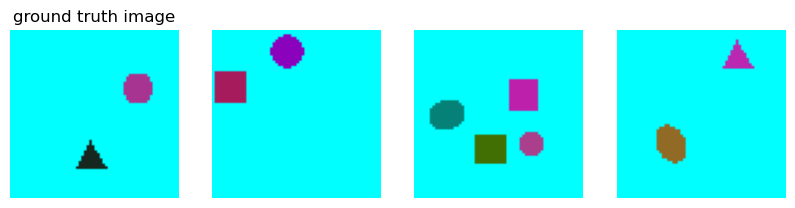

In [45]:
gt_image = img_batch.permute(0, 2, 3, 1).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(gt_image[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title('ground truth image')

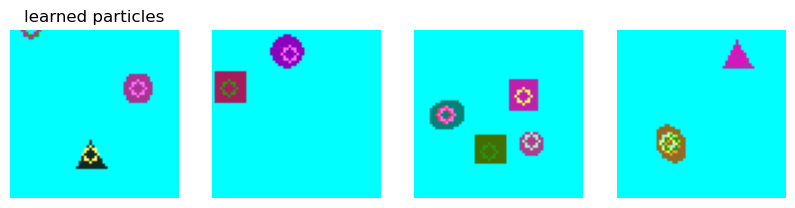

In [46]:
img_with_posterior_kp = img_with_kp.permute(0, 2, 3, 1).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_posterior_kp[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title('learned particles')

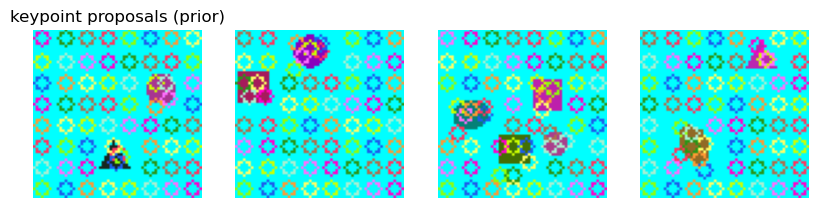

In [47]:
img_with_kp_proposals = img_with_kp_p.permute(0, 2, 3, 1).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_kp_proposals[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title('keypoint proposals (prior)')

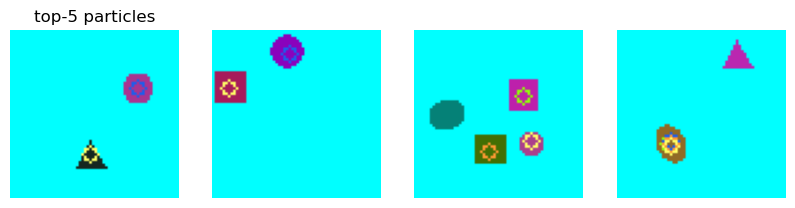

In [48]:
img_with_topk_kp = img_with_kp_topk.permute(0, 2, 3, 1).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_topk_kp[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'top-{topk} particles')

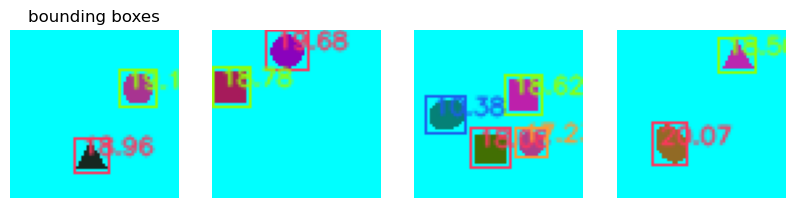

In [49]:
img_with_bb = img_with_masks_alpha_nms.permute(0, 2, 3, 1).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_bb[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'bounding boxes')

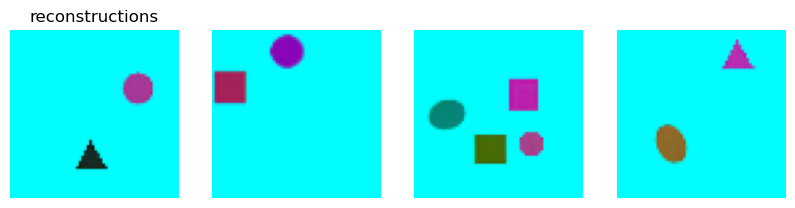

In [50]:
reconsturction = rec.permute(0, 2, 3, 1).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(reconsturction[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'reconstructions')

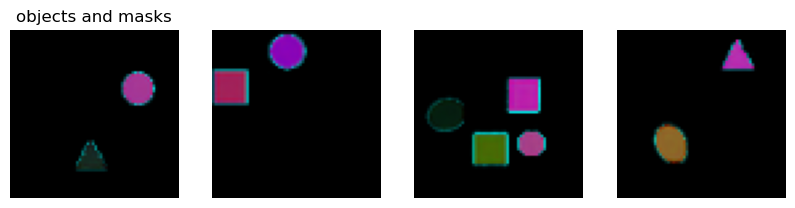

In [51]:
all_objects_with_masks = dec_objects.permute(0, 2, 3, 1).detach().cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(all_objects_with_masks[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'objects and masks')

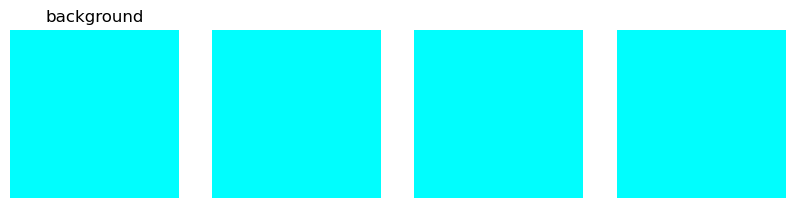

In [52]:
# background
bg_rec = bg.permute(0, 2, 3, 1).detach().cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(bg_rec[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'background')

In [54]:
# manipulation - let's move the particles a bit and see what happens
z_manip = z + 0.3
with torch.no_grad():
    decoder_dict = model.decode_all(z_manip, z_features, z_bg, obj_on, z_depth=z_depth, z_scale=z_scale)
rec_new = decoder_dict['rec']

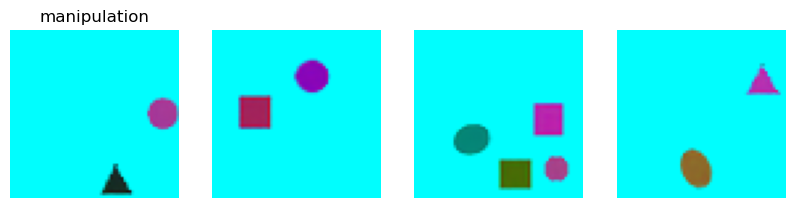

In [55]:
manip_reconstruction = rec_new.permute(0, 2, 3, 1).cpu().numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(manip_reconstruction[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'manipulation')

### <img src="https://img.icons8.com/external-flaticons-flat-flat-icons/64/000000/external-neural-network-the-future-flaticons-flat-flat-icons.png" style="height:50px;display:inline"> DDLP - Model
---
* DDLP extends DLPv2 to videos by introducing a particle tracking posterior learning process and a transformer-based dynamics module, to model the particle dynamics over time.
* In what follows, we will introduce the new components, while the rest of the model (FG + BG) remains the same as DLPv2.

#### Particle Tracking Posterior
---
* The posterior (encoder) in DLP uses a CNN applied to the image to propose keypoints. 
* However, simply treating each frame individually would not work, as **the order of the particles is not aligned between frames** and there is no guarantee that objects in consecutive frames will be assigned the same particle.

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/align_fig.png?raw=true" style="height:250px">

* We propose a tracking approach to achieve particle-alignment between frames, by predicting the keypoints of frame $x_t$ as *offsets* from the keypoints of frame $x_{t-1}$.
* For each particle, our tracking posterior takes as input the position in the previous frame $x_{t-1}$, and searches for the keypoint in frame $x_t$ in a patch centered on the previous position.
* Given a sequence of frames $\{x^t\}_{t=0}^{T-1}$ we perform an iterative encoding where in each step:<br>**(1)** The posterior keypoints from the previous step serve as anchors, from which an offset will be learned to the current step.<br>**(2)** To indicate the region in which the consecutive keypoint may be, the RGB patch input to the encoder is concatenated with an additional single-channel score-map generated by cross-correlating consecutive patches in time, implemented efficiently with group-convolution. 
* The single-channel generated score-map can help direct the search for the object in the consecutive frame. The score-map is concatenated channel-wise to the input of the encoder component that outputs the particle attributes from each glimpse.

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/cross_corr.png?raw=true" style="height:250px">

In [ ]:
# THIS CELL IS NOT MEANT TO BE RUN

# sequential encoding sketch
# for the first time step, standard encoding
# ...
fg_dict = self.fg_module.encode_all(x[:, 0], deterministic=deterministic, warmup=warmup, noisy=noisy,
                                    kp_init=kp_init, refinement_iter=True)
# unpack dictionary...
# initialize lists to collect all outputs
mus, logvars, zs, z_bases = [mu], [logvar], [z], [z_base]
mu_offsets, logvar_offsets = [mu_offset], [logvar_offset]
mu_featuress, logvar_featuress, z_featuress = [mu_features], [logvar_features], [z_features]
cropped_objectss = [cropped_objects]
obj_on_as, obj_on_bs, z_obj_ons = [obj_on_a], [obj_on_b], [z_obj_on]
mu_depths, logvar_depths, z_depths = [mu_depth], [logvar_depth], [z_depth]
mu_scales, logvar_scales, z_scales = [mu_scale], [logvar_scale], [z_scale]
# track
for i in range(1, timestep_horizon):
    # tracking, search for mu_tot in the area of the previous mu
    mu_prev = zs[-1].detach()
    cropped_objects_prev = cropped_objectss[-1].detach()
    cropped_objects_prev = cropped_objects_prev.view(-1, *cropped_objects_prev.shape[2:])
    mu_scale_prev = z_scales[-1].detach()
    fg_dict = self.fg_module.encode_all(x[:, i], deterministic=deterministic, warmup=warmup,
                                        noisy=noisy, kp_init=mu_prev,
                                        cropped_objects_prev=cropped_objects_prev, scale_prev=mu_scale_prev)

In [ ]:
# THIS CELL IS NOT MEANT TO BE RUN

# normalized cross-correlation with group-convolution
def correlate(x, kernel):
    groups = kernel.shape[0]
    output = F.conv2d(x, kernel, padding=0, groups=groups, stride=1, bias=None)
    norm = torch.sqrt(torch.sum(kernel ** 2) * F.conv2d(x ** 2, torch.ones_like(kernel), groups=groups,
                                                        bias=None, stride=1, padding=0) + 1e-10)
    output = output / (norm + 1e-5)
    return output

in0 = cropped_objects.reshape(1, -1, *cropped_objects.shape[2:])
# [1, bs * n_kp * ch, patch_size, patch_size]
in0 = pad_func(in0)
in1 = previous_objects.reshape(-1, *previous_objects.shape[1:])
# [bs * n_kp, ch, patch_size, patch_size]
output = correlate(x=in0, kernel=in1)

#### Generative Predictive Dynamics with Particle Interaction Transformer (PINT)
---

* The dynamics module models the prior distribution $p_{\psi}(z^{t+1}|z^t)$ of the particles' temporal evolution.
* We propose a stochastic Transformer-based prior dynamics module that is trained in conjunction with the posterior, and utilizes the attention mechanism to capture the interaction between particles over time in parallel.
* Our proposed dynamics module, termed *Particle Interaction Transformer (PINT)*, is a causal Transformer decoder based on the design of Generative Pre-trained Transformer (GPT).
* Given the set of reparameterized particles $Z = \{(z_0, ..., z_{K-1}, z_{\text{bg}})^t\}_{t=0}^{T-2}$, where $T$ is the prediction horizon and $z_{\text{bg}}$ is a special particle representing the background, PINT outputs the one-step future prediction $\hat{Z}=\{(\hat{z}_0, ..., \hat{z}_{K-1}, \hat{z}_{\text{bg}})^t\}_{t=1}^{T-1}$.
* We do not add positional embeddings before the attention layers, but add a learned per-head **relative positional bias** which is directly added to the attention matrix before the softmax operation.
* We decompose the added relative positional bias to a *temporal* relative positional bias and a *spatial* relative bias. 
* The temporal embedding matrix $B_{\text{time}} \in \mathbb{R}^{T \times T}$ assures that all particles in the same time-step get the same relative temporal encoding, while the spatial embedding matrix $B_{\text{pos}} \in \mathbb{R}^{(K+1) \times (K+1)}$ assures that each particle is assigned a unique relative embedding through time.
* $B_{\text{time}}$ and $B_{\text{pos}}$ are repeated $(K+1)$ and $T$ times respectively, and summed to create the relative positional bias matrix $B = B_{\text{time}} + B_{\text{pos}} \in \mathbb{R}^{\left((K+1) T\right) \times \left((K+1)T\right)}, B(i, j) = b_i^j = b_i +b^j $, where $i$ denotes the relative time and $j$ the relative particle. <img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/rel_bias_left.png?raw=true" style="height:250px"> <img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/rel_pos_fig.png?raw=true" style="height:250px">
* To model particle interactions, the attention operation is modified such that particles attend to each other in the same time-step and across time, i.e., the attention matrix $A \in \mathbb{R}^{\left((K+1) T\right) \times \left((K+1) T\right)}$, and similarly to GPT we use a causal mask to ensure the attention only considers past inputs. <img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/causal_att.png?raw=true" style="height:250px">

In [ ]:
# THIS CELL IS NOT MEANT TO BE RUN

# causal particle attention + relative positional bias
class CausalParticleSelfAttention(nn.Module):
    """
    A particle-based multi-head masked self-attention layer with a projection at the end.
    """

    def __init__(self, n_embed, n_head, block_size, attn_pdrop=0.1, resid_pdrop=0.1,
                 positional_bias=False, max_particles=None, linear_bias=False):
        super().__init__()
        assert n_embed % n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(n_embed, n_embed, bias=linear_bias)
        self.query = nn.Linear(n_embed, n_embed, bias=linear_bias)
        self.value = nn.Linear(n_embed, n_embed, bias=linear_bias)
        # regularization
        self.attn_drop = nn.Dropout(attn_pdrop)
        self.resid_drop = nn.Dropout(resid_pdrop)
        # output projection
        self.proj = nn.Linear(n_embed, n_embed, bias=linear_bias)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size))
                             .view(1, 1, 1, block_size, 1, block_size))
        self.n_head = n_head
        self.positional_bias = positional_bias
        self.max_particles = max_particles
        if self.positional_bias:
            self.rel_pos_bias = SimpleRelativePositionalBias(block_size, n_head, max_particles=max_particles)
        else:
            self.rel_pos_bias = nn.Identity()

    def forward(self, x):
        B, N, T, C = x.size()  # batch size, n_particles, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, N * T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, N * T, hs)
        q = self.query(x).view(B, N * T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, N * T, hs)
        v = self.value(x).view(B, N * T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, N * T, hs)

        # causal self-attention; Self-attend: (B, nh, N * T, hs) x (B, nh, hs, N  *T) -> (B, nh, N * T, N *T )
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))  # (B, nh, N * T, N * T)
        att = att.view(B, -1, N, T, N, T)  # (B, nh, N, T, N, T)
        if self.positional_bias:
            if self.max_particles is not None:
                bias_t, bias_p = self.rel_pos_bias(T, num_particles=N)
                bias_t = bias_t.view(1, bias_t.shape[1], 1, T, 1, T)
                bias_p = bias_p.view(1, bias_p.shape[1], N, 1, N, 1)
                att = att + bias_t + bias_p
            else:
                bias_t, _ = self.rel_pos_bias(T)
                bias_t = bias_t.view(1, bias_t.shape[1], 1, T, 1, T)
                att = att + bias_t
        att = att.masked_fill(self.mask[:, :, :, :T, :, :T] == 0, float('-inf'))
        att = att.view(B, -1, N * T, N * T)  # (B, nh, N * T, N * T)
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, N*T, N*T) x (B, nh, N*T, hs) -> (B, nh, N*T, hs)
        y = y.transpose(1, 2).contiguous().view(B, N * T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        y = y.view(B, N, T, -1)
        return y

The following figure summarizes the DDLP model:

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/arch_fig_pp.png?raw=true" style="height:350px">

* Input are frames $\{x\}_0^{T-1}$. 
* For each $0\leq t \leq T-1$, a particle encoder produces the latent particle representation $z_t$ given $x_t$ and $z_{t-1}$; this encoder tracks the particles to induce consistency between frames. 
* Each individual latent $z_{t}$ is fed through the particle decoder to produce the reconstruction of frame $\hat{x}_{t}$. 
* A Transformer-based dynamics module models the prior distribution parameters $\{ \hat{z}\}_1^{T-1}$ given $\{ z\}_0^{T-2}$, and a KL loss term minimizes the distance between the prior $\{ \hat{z}\}_1^{T-1}$ and posterior $\{ z\}_1^{T-1}$.

### <img src="https://img.icons8.com/external-bearicons-gradient-bearicons/64/external-Example-miscellany-texts-and-badges-bearicons-gradient-bearicons.png" style="height:50px;display:inline"> DDLP - Hyperparameters and Example Usage
---
* We will now create an instance of DDLP and look at its functions outputs.
* More details are available in `/docs/example_usage.py`.

In [16]:
# example hyper-parameters
batch_size = 32
beta_kl = 0.1
beta_rec = 1.0
kl_balance = 0.001  # balance between spatial attributes (x, y, scale, depth) and visual features
n_kp_enc = 12
n_kp_prior = 15
patch_size = 8  # patch size for the prior to generate prior proposals
learned_feature_dim = 6  # visual features
anchor_s = 0.25  # effective patch size for the posterior: anchor_s * image_size
image_size = 64
ch = 3
enc_channels = [32, 64, 128]
prior_channels = (32, 32, 64)


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
use_correlation_heatmaps = True # for tracking, set True to use correlation heatmaps between patches
pint_layers = 6  # transformer-based dynamics module number of layers
pint_heads = 8  # transformer-based dynamics module attention heads
pint_dim = 256  # transformer-based dynamics module inner dimension (+projection dim)
beta_dyn = 0.1  # beta-kl for the dynamics loss
num_static_frames = 4  # "burn-in frames", number of initial frames with kl w.r.t. constant prior (as in DLPv2)

print("--- DDLP ---")

# create model
model = ObjectDynamicsDLP(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                          image_size=image_size, learned_feature_dim=learned_feature_dim,
                          patch_size=patch_size, n_kp_enc=n_kp_enc, n_kp_prior=n_kp_prior,
                          anchor_s=anchor_s, use_correlation_heatmaps=use_correlation_heatmaps,
                          pint_layers=pint_layers, pint_heads=pint_heads, pint_dim=pint_dim).to(device)
print(f'model.info():')
print(model.info())

--- DDLP ---
model.info():
prior (patch) kp filtering: 64 -> prior kp: 15
prior (patch) kp filtering method: variance
prior patch size: 8
# posterior particles: 12
particle visual feature dim: 6
bg visual feature dim: 6
posterior object patch size: 16
cnn pre-pool out sizes: prior-torch.Size([64, 2, 2]), obj enc-torch.Size([64, 4, 4]), bg enc-torch.Size([128, 16, 16])
object decoder # upsampling layers: 1
correlation maps for tracking: True
pint relative positional bias: True
pint trainable parameters: 5085552 (5.0856M)
trainable parameters: 9700348 (9.7003M)
estimated size on disk: 37.006MB



In [17]:
timestep_horizon = 10
x = torch.rand(batch_size, timestep_horizon + 1, ch, image_size, image_size, device=device)
# complete forward
model_output = model(x)
# let's see what's inside
print(f'model(x) output:')
for k in model_output.keys():
    print(f'{k}: {model_output[k].shape}')

model(x) output:
kp_p: torch.Size([352, 15, 2])
rec: torch.Size([352, 3, 64, 64])
mu: torch.Size([352, 12, 2])
logvar: torch.Size([352, 12, 2])
z_base: torch.Size([352, 12, 2])
z: torch.Size([352, 12, 2])
z_kp_bg: torch.Size([352, 1, 2])
mu_offset: torch.Size([352, 12, 2])
logvar_offset: torch.Size([352, 12, 2])
mu_features: torch.Size([352, 12, 6])
logvar_features: torch.Size([352, 12, 6])
z_features: torch.Size([352, 12, 6])
bg: torch.Size([352, 3, 64, 64])
mu_bg: torch.Size([352, 6])
logvar_bg: torch.Size([352, 6])
z_bg: torch.Size([352, 6])
cropped_objects_original: torch.Size([352, 12, 3, 16, 16])
obj_on_a: torch.Size([352, 12])
obj_on_b: torch.Size([352, 12])
obj_on: torch.Size([352, 12])
dec_objects_original: torch.Size([352, 12, 4, 16, 16])
dec_objects: torch.Size([352, 3, 64, 64])
mu_depth: torch.Size([352, 12, 1])
logvar_depth: torch.Size([352, 12, 1])
z_depth: torch.Size([352, 12, 1])
mu_scale: torch.Size([352, 12, 2])
logvar_scale: torch.Size([352, 12, 2])
z_scale: torch.Si

**posterior**: similar to DLPv2, but the first dimension is `batch_size * num_frames` for all:

`kp_p`: torch.Size([352, 15, 2])

`rec`: torch.Size([352, 3, 64, 64])

`mu`: torch.Size([352, 12, 2])

`logvar`: torch.Size([352, 12, 2])

`z_base`: torch.Size([352, 12, 2])

`z`: torch.Size([352, 12, 2])

`z_kp_bg`: torch.Size([352, 1, 2])

`mu_offset`: torch.Size([352, 12, 2])

`logvar_offset`: torch.Size([352, 12, 2])

`mu_features`: torch.Size([352, 12, 6])

`logvar_features`: torch.Size([352, 12, 6])

`z_features`: torch.Size([352, 12, 6])

`bg`: torch.Size([352, 3, 64, 64])

`mu_bg`: torch.Size([352, 6])

`logvar_bg`: torch.Size([352, 6])

`z_bg`: torch.Size([352, 6])

`cropped_objects_original`: torch.Size([352, 12, 3, 16, 16])

`obj_on_a`: torch.Size([352, 12])

`obj_on_b`: torch.Size([352, 12])

`obj_on`: torch.Size([352, 12])

`dec_objects_original`: torch.Size([352, 12, 4, 16, 16])

`dec_objects`: torch.Size([352, 3, 64, 64])

`mu_depth`: torch.Size([352, 12, 1])

`logvar_depth`: torch.Size([352, 12, 1])

`z_depth`: torch.Size([352, 12, 1])

`mu_scale`: torch.Size([352, 12, 2])

`logvar_scale`: torch.Size([352, 12, 2])

`z_scale`: torch.Size([352, 12, 2])

`alpha_masks`: torch.Size([352, 12, 1, 64, 64])

**prior dynamics**:

`mu_dyn`: torch.Size([32, 10, 12, 2])  # dynamics-prior position for t=1->T-1 given t=0->T-2

`logvar_dyn`: torch.Size([32, 10, 12, 2])  # dynamics-prior position for t=1->T-1 given t=0->T-2

`mu_features_dyn`: torch.Size([32, 10, 12, 6])  # dynamics-prior visual appearance for t=1->T-1 given t=0->T-2

`logvar_features_dyn`: torch.Size([32, 9, 12, 6])  # dynamics-prior visual appearance for t=1->T-1 given t=0->T-2

`obj_on_a_dyn`: torch.Size([32, 10, 12])  # dynamics-prior transparency for t=1->T-1 given t=0->T-2

`obj_on_b_dyn`: torch.Size([32, 10, 12])  # dynamics-prior transparency for t=1->T-1 given t=0->T-2

`mu_depth_dyn`: torch.Size([32, 10, 12, 1])  # dynamics-prior depth for t=1->T-1 given t=0->T-2

`logvar_depth_dyn`: torch.Size([32, 10, 12, 1])  # dynamics-prior depth for t=1->T-1 given t=0->T-2

`mu_scale_dyn`: torch.Size([32, 10, 12, 2])  # dynamics-prior scale for t=1->T-1 given t=0->T-2

`logvar_scale_dyn`: torch.Size([32, 10, 12, 2])  # dynamics-prior scale for t=1->T-1 given t=0->T-2

`mu_bg_dyn`: torch.Size([32, 10, 6])  # dynamics-prior background appearance for t=1->T-1 given t=0->T-2

`logvar_bg_dyn`: torch.Size([32, 10, 6])  # dynamics-prior background appearance for t=1->T-1 given t=0->T-2

In [18]:
# loss calculation
all_losses = model.calc_elbo(x, model_output, beta_kl=beta_kl,
                             beta_rec=beta_rec, kl_balance=kl_balance, beta_dyn=beta_dyn,
                             num_static=num_static_frames,
                             recon_loss_type="mse")
# let's see what's inside
print(f'model.calc_elbo(): model losses:')
for k in all_losses.keys():
    print(f'{k}: {all_losses[k]}')

model.calc_elbo(): model losses:
loss: 465.182861328125
psnr: 10.780303955078125
kl: 2499.2744140625
kl_dyn: 401.8912048339844
loss_rec: 4826.89501953125
obj_on_l1: 6.043821334838867
loss_kl_kp: 979.3345947265625
loss_kl_feat: 0.23109710216522217
loss_kl_obj_on: 56.53932189941406
loss_kl_scale: 1463.400146484375
loss_kl_depth: 0.023124443367123604


`loss`: the complete loss (for `loss.backward()`)

`psnr`: mean PSNR

`kl`: complete kl-divergence (of all components)

`kl_dyn`: # dynamics kl

`loss_rec`: reconstruction loss

`obj_on_l1`: if all particles are "on" then obj_on_l1=n_particles, effective # of visible particles

`loss_kl_kp`: kl of the position

`loss_kl_feat`: kl of the visual features

`loss_kl_obj_on`: kl of the transparency

`loss_kl_scale`: kl of the scale

`loss_kl_depth`: kl of the depth

In [19]:
# sampling
num_steps = 15  # how many frames to generate
cond_steps = 5  # how many frames are conditional
x = torch.rand(1, num_steps + cond_steps, ch, image_size, image_size, device=device)
sample_out, sample_z_out = model.sample(x, cond_steps=cond_steps, num_steps=num_steps, deterministic=True,
                                        return_z=True)
# let's see what's inside
print(f'model.sample(): model dynamics unrolling:')
print(f'sample_out: {sample_out.shape}')
print(f'sample_z_out:')
for k in sample_z_out.keys():
    print(f'{k}: {sample_z_out[k].shape}')

model.sample(): model dynamics unrolling:
sample_out: torch.Size([1, 20, 3, 64, 64])
sample_z_out:
z_pos: torch.Size([1, 20, 12, 2])
z_scale: torch.Size([1, 20, 12, 2])
z_obj_on: torch.Size([1, 20, 12])
z_depth: torch.Size([1, 20, 12, 1])
z_features: torch.Size([1, 20, 12, 6])
z_bg_features: torch.Size([1, 20, 6])
z_ids: torch.Size([1, 20, 12])


`sample_out`: torch.Size([1, 20, 3, 64, 64])  #  generated frames

`sample_z_out`:  # latent unrolls

`z_pos`: torch.Size([1, 20, 12, 2])

`z_scale`: torch.Size([1, 20, 12, 2])

`z_obj_on`: torch.Size([1, 20, 12])

`z_depth`: torch.Size([1, 20, 12, 1])

`z_features`: torch.Size([1, 20, 12, 6])

`z_bg_features`: torch.Size([1, 20, 6])

`z_ids`: torch.Size([1, 20, 12])  #  this is only used for the balls-interaction dataset, each particle gets an id

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com